## Telecom Churn Case Study

### Objective

With this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Business Goal

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

### Loading & Importing the Required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import scale
from sklearn import svm
from sklearn import metrics
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings('ignore')


### Importing Telecom Data

In [3]:
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [4]:
telecom_df.info()
telecom_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2)

mobile_number            0.00
circle_id                0.00
loc_og_t2o_mou           1.02
std_og_t2o_mou           1.02
loc_ic_t2o_mou           1.02
last_date_of_month_6     0.00
last_date_of_month_7     0.60
last_date_of_month_8     1.10
last_date_of_month_9     1.66
arpu_6                   0.00
arpu_7                   0.00
arpu_8                   0.00
arpu_9                   0.00
onnet_mou_6              3.94
onnet_mou_7              3.86
onnet_mou_8              5.38
onnet_mou_9              7.75
offnet_mou_6             3.94
offnet_mou_7             3.86
offnet_mou_8             5.38
offnet_mou_9             7.75
roam_ic_mou_6            3.94
roam_ic_mou_7            3.86
roam_ic_mou_8            5.38
roam_ic_mou_9            7.75
roam_og_mou_6            3.94
roam_og_mou_7            3.86
roam_og_mou_8            5.38
roam_og_mou_9            7.75
loc_og_t2t_mou_6         3.94
                        ...  
arpu_2g_9               74.08
night_pck_user_6        74.85
night_pck_

### Data Preparation
###### Scoping our sample to the High valued customer (top 30%) who demonstrated high spending in the initial two months.Churn Indicator created based on the provided business logics

In [6]:
# create Churn data
telecom_df1 = telecom_df
telecom_df1['total_rech_amt_good_phase'] = (telecom_df1['total_rech_amt_6'] + telecom_df1['total_rech_amt_7'])/2
telecom_df1 = telecom_df1[telecom_df1['total_rech_amt_good_phase'] > telecom_df1['total_rech_amt_good_phase'].quantile(0.70)]

telecom_df1['total_usage_col'] = telecom_df1['total_og_mou_9'] + telecom_df1['total_ic_mou_9'] + telecom_df1['vol_2g_mb_9'] + telecom_df1['vol_3g_mb_9']

telecom_df1['churn'] = np.where(telecom_df1['total_usage_col']== 0, 1, 0)
telecom_df1['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

In [7]:
telecom_df1 = telecom_df1.drop(['total_rech_amt_good_phase','total_usage_col'],1)

As per the analysis scope dropping all the variables of the 9th month after the churn indicator creation

In [8]:
nine_col = [col for col in telecom_df1.columns if '_9' in col]
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop(nine_col, axis = 1)
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop('sep_vbc_3g', axis=1)

(29979, 227)
(29979, 173)


### Churn rate-

In [9]:
y = telecom_df1['churn']
churn = (sum(y)/len(y.index))*100
print(churn)
print(telecom_df1.shape)

8.636045231662164
(29979, 172)


In [10]:
telecom_df1.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.0,29865.0,29865.0,29865.0,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,...,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,109.0,0.0,0.0,0.0,587.587624,589.424681,535.067748,299.392147,307.701888,...,0.150339,0.140498,0.897603,0.889804,0.837322,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,0.0,0.0,0.0,0.0,442.848876,463.049067,492.447887,462.369385,483.432401,...,0.969779,0.975212,0.303184,0.313147,0.369087,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,109.0,0.0,0.0,0.0,364.352500,365.235000,289.782000,43.030000,42.775000,...,0.000000,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,109.0,0.0,0.0,0.0,495.951000,493.781000,452.232000,128.480000,128.120000,...,0.000000,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,109.0,0.0,0.0,0.0,704.184500,700.986000,671.349500,357.655000,365.127500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.00000


In [11]:
round(100*(telecom_df1.isnull().sum()/len(telecom_df1.index)), 2)

mobile_number            0.00
circle_id                0.00
loc_og_t2o_mou           0.38
std_og_t2o_mou           0.38
loc_ic_t2o_mou           0.38
last_date_of_month_6     0.00
last_date_of_month_7     0.10
last_date_of_month_8     0.52
arpu_6                   0.00
arpu_7                   0.00
arpu_8                   0.00
onnet_mou_6              1.05
onnet_mou_7              1.01
onnet_mou_8              3.13
offnet_mou_6             1.05
offnet_mou_7             1.01
offnet_mou_8             3.13
roam_ic_mou_6            1.05
roam_ic_mou_7            1.01
roam_ic_mou_8            3.13
roam_og_mou_6            1.05
roam_og_mou_7            1.01
roam_og_mou_8            3.13
loc_og_t2t_mou_6         1.05
loc_og_t2t_mou_7         1.01
loc_og_t2t_mou_8         3.13
loc_og_t2m_mou_6         1.05
loc_og_t2m_mou_7         1.01
loc_og_t2m_mou_8         3.13
loc_og_t2f_mou_6         1.05
                        ...  
vol_3g_mb_8              0.00
arpu_3g_6               62.02
arpu_3g_7 

#### Dropping colums with only one unique value (showing zero variance)

In [12]:
#delete coloum as all value are zero or constant
telecom_df2 = telecom_df1.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                     'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)

In [13]:
print(telecom_df2.shape)

(29979, 159)


In [14]:
#Dropping columns
fields_to_be_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2 = telecom_df2.drop([field_to_be_imputed_with_2], 1)
        
print(telecom_df2.shape)

(29979, 129)


In [15]:
fields_to_be_imputed_with_2 = ['date_of_last_rech']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2[field_to_be_imputed_with_2].fillna(telecom_df2[field_to_be_imputed_with_2].mode()[0], inplace=True)

In [16]:
telecom_df2['date_of_last_rech_6'] = pd.to_datetime(telecom_df2.date_of_last_rech_6).dt.day
telecom_df2['date_of_last_rech_7'] = pd.to_datetime(telecom_df2.date_of_last_rech_7).dt.day
telecom_df2['date_of_last_rech_8'] = pd.to_datetime(telecom_df2.date_of_last_rech_8).dt.day

#### Imputing missing observations with Median column value

In [17]:
missing_cols = telecom_df2.columns[telecom_df2.isnull().sum()>0]
for col in missing_cols:
    telecom_df2[col].fillna((telecom_df2[col].median()), inplace=True)

In [18]:
round(100*(telecom_df2.isnull().sum()/len(telecom_df2.index)), 2)

mobile_number          0.0
arpu_6                 0.0
arpu_7                 0.0
arpu_8                 0.0
onnet_mou_6            0.0
onnet_mou_7            0.0
onnet_mou_8            0.0
offnet_mou_6           0.0
offnet_mou_7           0.0
offnet_mou_8           0.0
roam_ic_mou_6          0.0
roam_ic_mou_7          0.0
roam_ic_mou_8          0.0
roam_og_mou_6          0.0
roam_og_mou_7          0.0
roam_og_mou_8          0.0
loc_og_t2t_mou_6       0.0
loc_og_t2t_mou_7       0.0
loc_og_t2t_mou_8       0.0
loc_og_t2m_mou_6       0.0
loc_og_t2m_mou_7       0.0
loc_og_t2m_mou_8       0.0
loc_og_t2f_mou_6       0.0
loc_og_t2f_mou_7       0.0
loc_og_t2f_mou_8       0.0
loc_og_t2c_mou_6       0.0
loc_og_t2c_mou_7       0.0
loc_og_t2c_mou_8       0.0
loc_og_mou_6           0.0
loc_og_mou_7           0.0
                      ... 
max_rech_amt_8         0.0
date_of_last_rech_6    0.0
date_of_last_rech_7    0.0
date_of_last_rech_8    0.0
last_day_rch_amt_6     0.0
last_day_rch_amt_7     0.0
l

In [19]:
telecom_df3 = telecom_df2
telecom_df3.shape

(29979, 129)

#### Outlier Treatment

In [20]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])
#As we can see we have outlier.

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,587.587624,589.424681,535.067748,297.590611,305.886840,271.137938,421.142281,426.990330,383.029940,...,0.185296,0.173321,0.138063,0.150339,0.140498,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,442.848876,463.049067,492.447887,460.257092,481.318377,465.205131,468.998414,485.030117,473.464516,...,0.620703,0.583178,0.875984,0.969779,0.975212,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
1%,7.000028e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000


In [21]:
cont_cols = [col for col in telecom_df3.columns if col not in ['churn','mobile_number']]

for col in cont_cols:
    percentiles = telecom_df3[col].quantile([0.01,0.99]).values
    telecom_df3[col][telecom_df3[col] <= percentiles[0]] = percentiles[0]
    telecom_df3[col][telecom_df3[col] >= percentiles[1]] = percentiles[1]

In [22]:
telecom_df3.shape

(29979, 129)

In [23]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,578.115790,579.934200,524.618925,288.909740,296.580898,261.866393,413.363109,418.408660,373.082685,...,0.173288,0.163815,0.100304,0.103239,0.093966,1263.461223,120.468609,126.130999,112.271333,0.08636
std,6.846594e+05,336.036348,338.202040,370.788082,404.375323,419.262037,398.634242,420.037947,429.176148,401.058913,...,0.520151,0.505309,0.427528,0.442786,0.431060,973.137375,318.585454,337.364761,313.189126,0.28090
min,7.000000e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
1%,7.000028e+09,18.228064,25.732732,0.000000,0.000000,0.000000,0.000000,1.059516,1.107580,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000


### Creating derived columns

Average values of 3 months for each attributes were created to check if that value could address all the months.
Median value of Internet usage (2G + 3G) across months was created to capture the churn rate as it was observed majority of the churn happens when the internet usage pattern shows a decline
The AON variable was used to create tenure buckets. It was observed larger the tenure, lesser was the churn - as customers who are newly acquired to the network churned more as compared to the old customers.

In [24]:
telecom_df3['int_usage_median'] = telecom_df3[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_df3['int_usage_median'] = telecom_df3.int_usage_median.map(lambda x: 1 if x == 0 else 0)
telecom_df3 = telecom_df3.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


telecom_df3['tenure_buck'] = np.round(telecom_df3['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df3['tenure_buck'] = pd.cut(telecom_df3['tenure_buck'], bins)
telecom_df3['tenure_buck'].value_counts()

(4, 10]    9681
(1, 2]     7486
(0, 1]     5320
(2, 3]     4530
(3, 4]     2962
Name: tenure_buck, dtype: int64

### Correlation Analysis

In [25]:
# Create correlation matrix
corr_matrix = telecom_df3.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop

telecom_df3 = telecom_df3.drop(to_drop, 1)

In [26]:
telecom_df3.tenure_buck.dtype

CategoricalDtype(categories=[(0, 1], (1, 2], (2, 3], (3, 4], (4, 10]],
              ordered=True)

In [27]:
#create dummy for tenure_buck 
telecom_df3 = pd.get_dummies(telecom_df3, drop_first=True)

In [28]:
telecom_df3.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [29]:
# After outlier treatment droping column which don't have much variance or zero variance
telecom_df4 = telecom_df3.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [30]:
telecom_df4.shape

(29979, 66)

In [31]:
round(100*(telecom_df3.isnull().sum()/len(telecom_df3.index)), 2)

mobile_number          0.0
arpu_6                 0.0
arpu_7                 0.0
arpu_8                 0.0
onnet_mou_6            0.0
offnet_mou_6           0.0
offnet_mou_7           0.0
roam_ic_mou_6          0.0
roam_ic_mou_7          0.0
roam_ic_mou_8          0.0
loc_og_t2t_mou_6       0.0
loc_og_t2m_mou_6       0.0
loc_og_t2f_mou_6       0.0
loc_og_t2c_mou_6       0.0
loc_og_t2c_mou_7       0.0
loc_og_t2c_mou_8       0.0
std_og_t2f_mou_6       0.0
std_og_t2f_mou_7       0.0
std_og_t2f_mou_8       0.0
isd_og_mou_6           0.0
spl_og_mou_6           0.0
spl_og_mou_7           0.0
spl_og_mou_8           0.0
og_others_6            0.0
og_others_7            0.0
og_others_8            0.0
loc_ic_t2t_mou_6       0.0
loc_ic_t2m_mou_6       0.0
loc_ic_t2f_mou_6       0.0
std_ic_t2t_mou_6       0.0
                      ... 
total_rech_num_6       0.0
total_rech_num_7       0.0
max_rech_amt_6         0.0
max_rech_amt_7         0.0
max_rech_amt_8         0.0
date_of_last_rech_6    0.0
d

### Exploratory data analysis

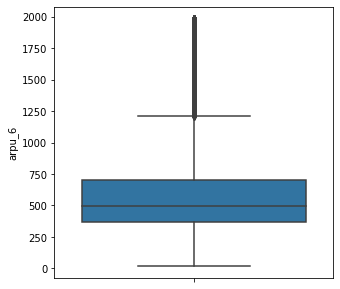

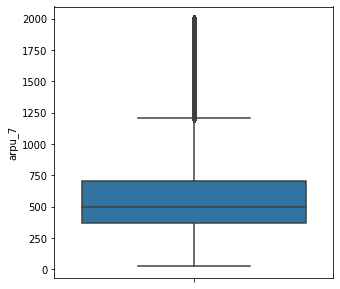

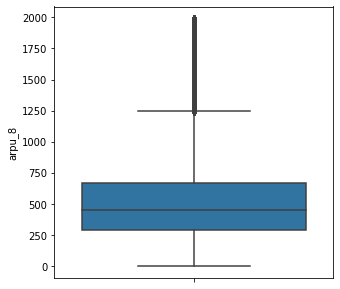

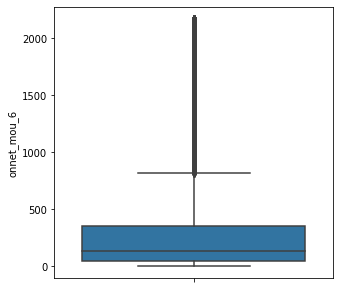

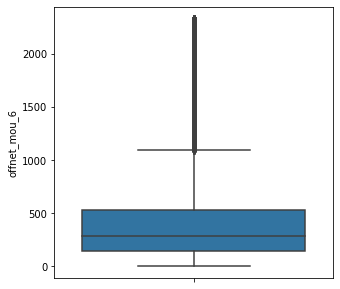

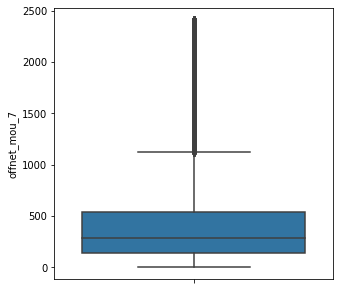

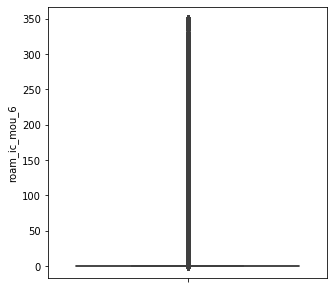

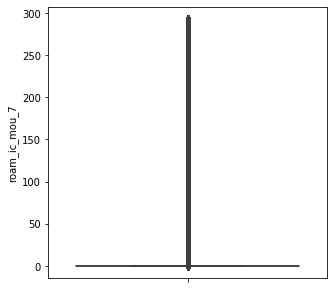

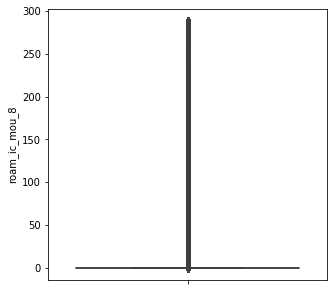

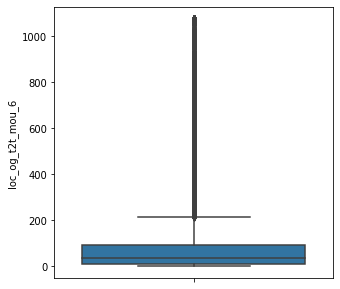

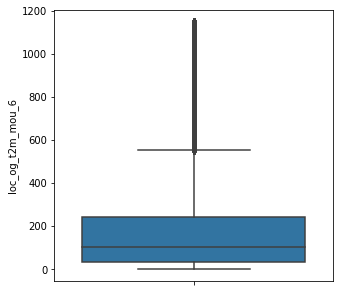

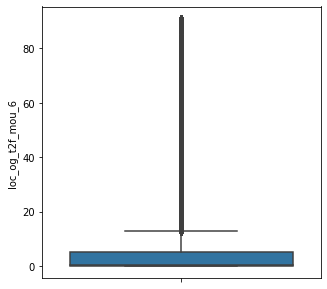

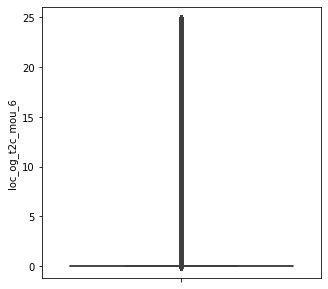

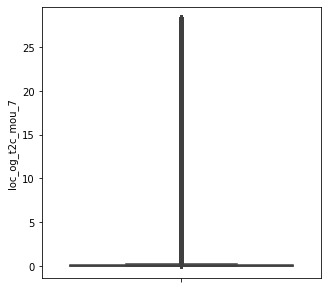

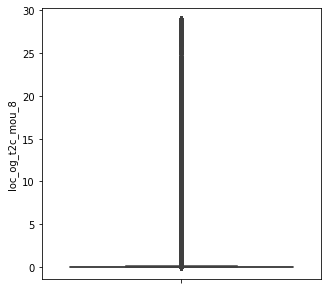

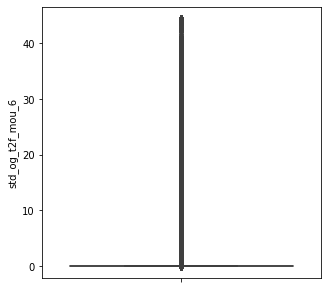

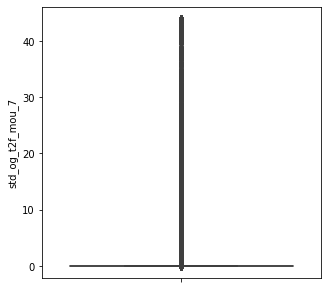

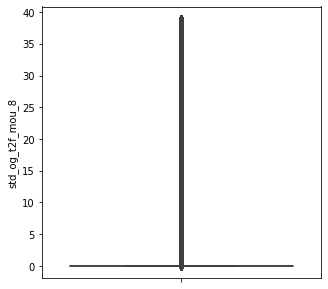

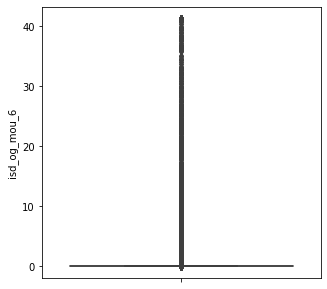

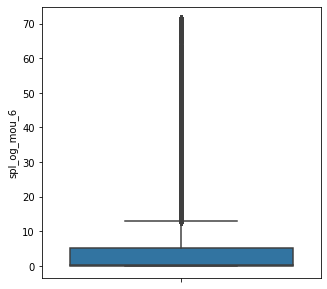

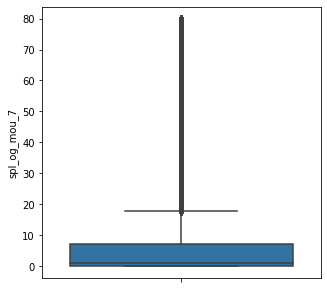

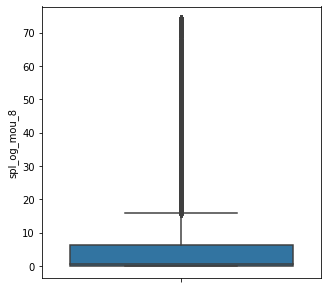

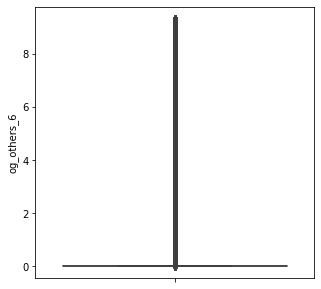

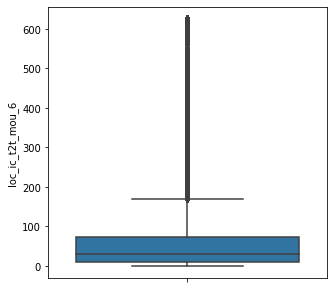

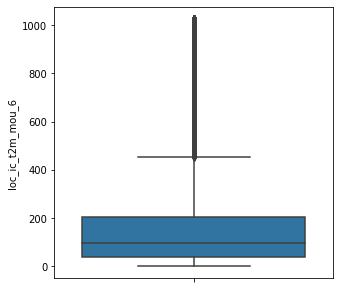

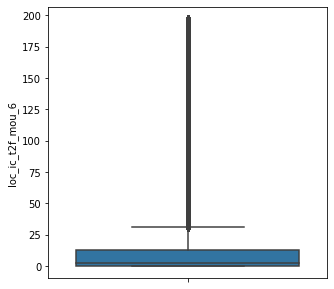

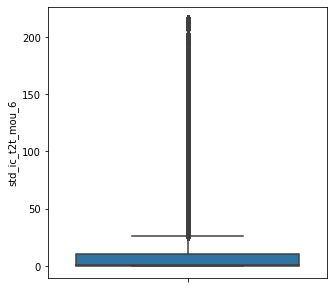

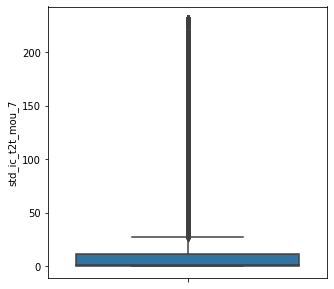

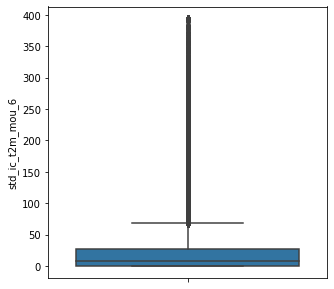

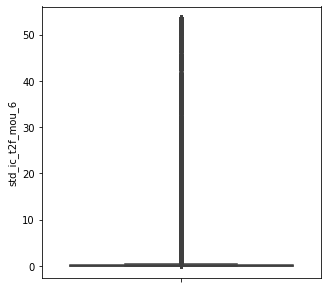

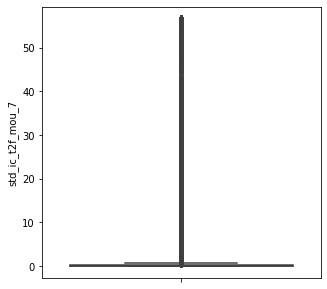

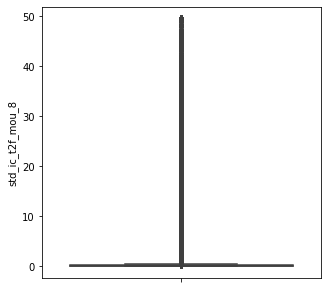

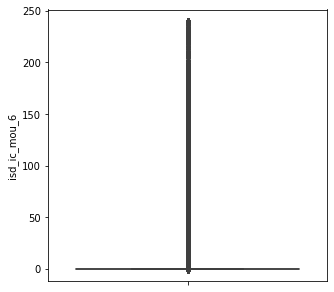

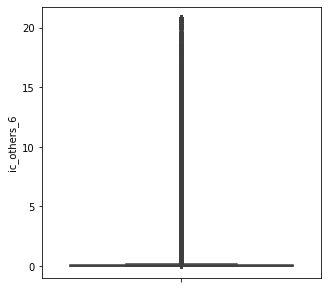

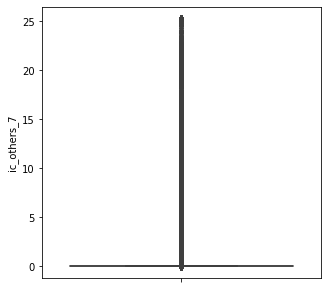

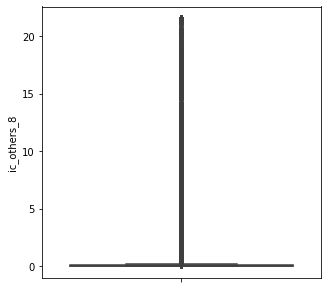

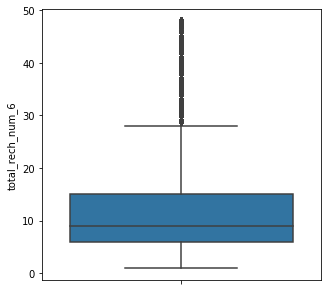

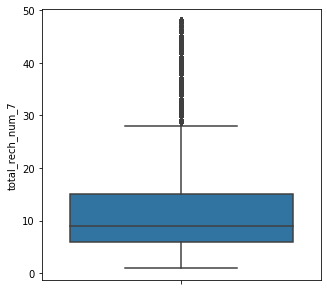

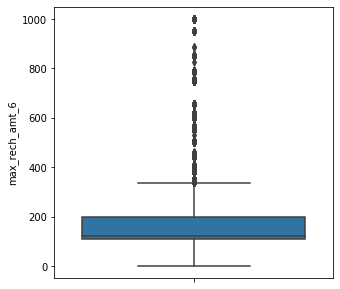

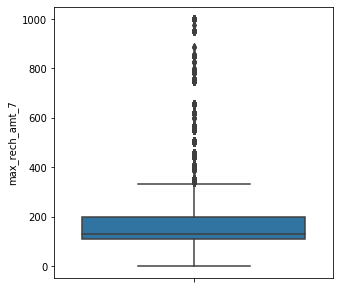

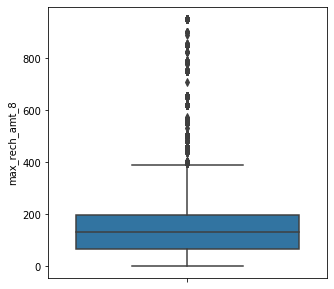

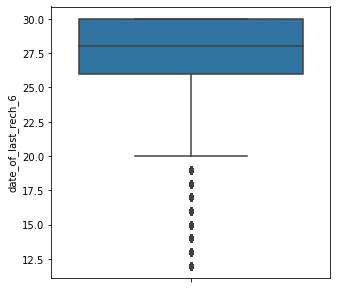

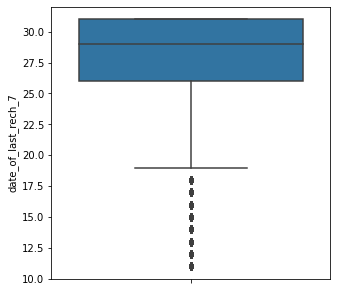

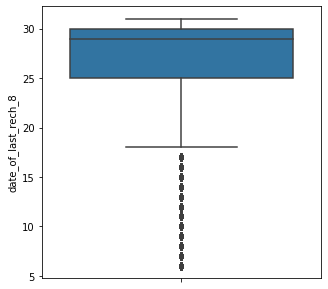

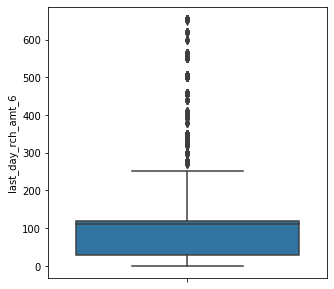

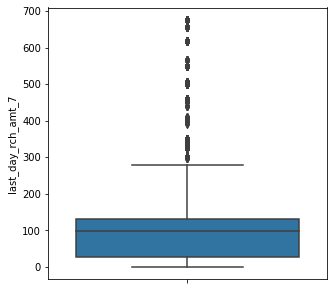

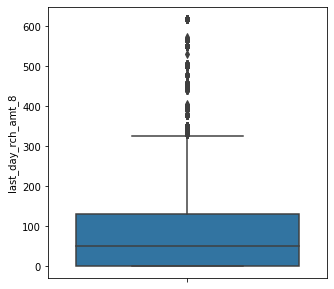

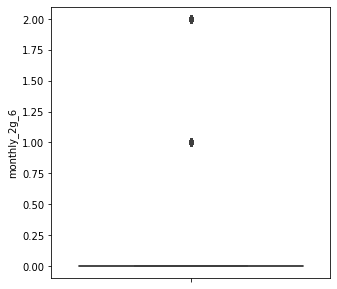

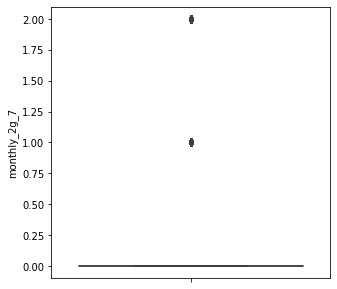

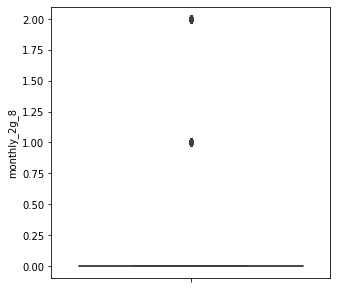

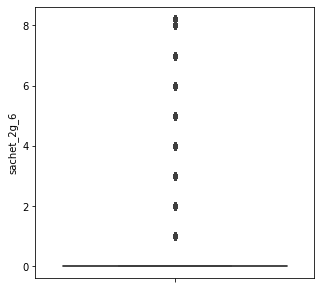

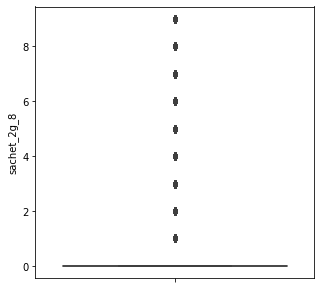

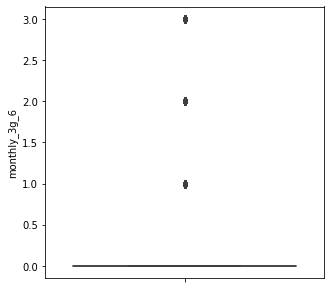

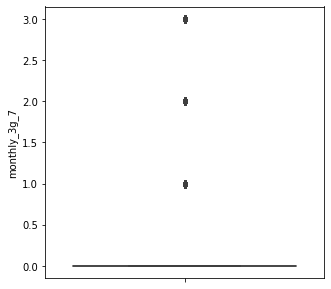

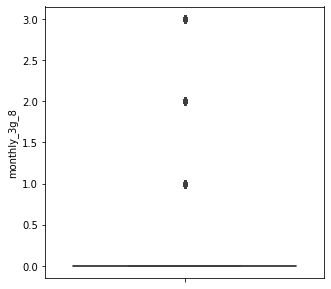

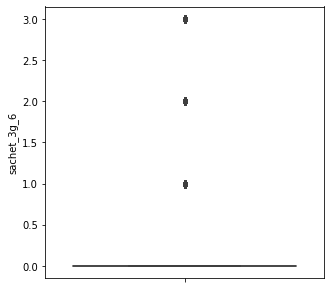

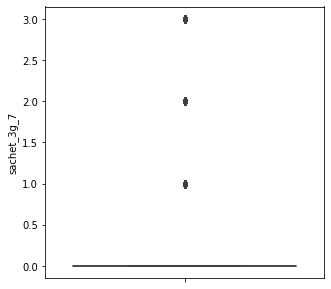

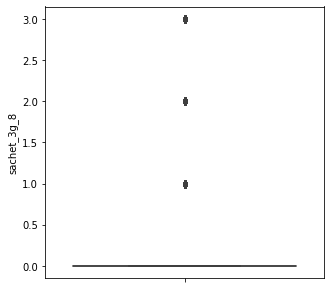

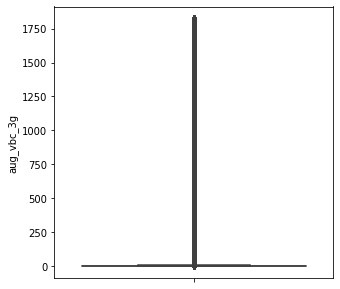

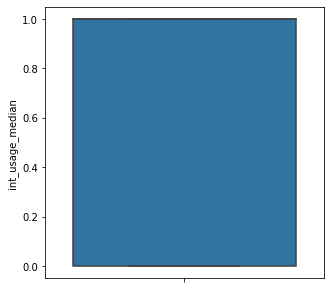

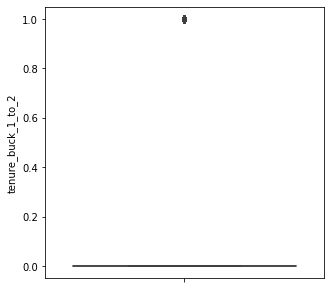

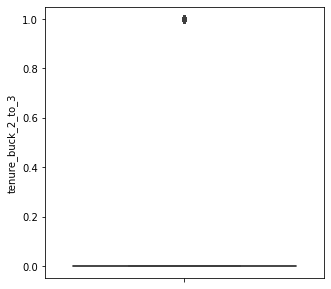

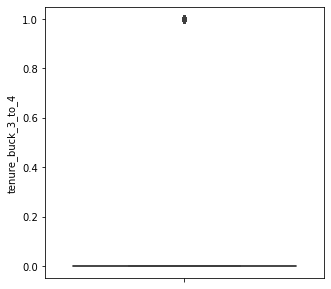

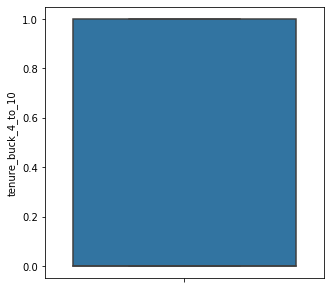

In [32]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=telecom_df4)

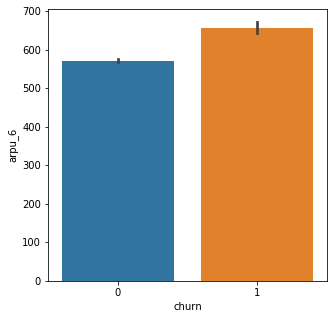

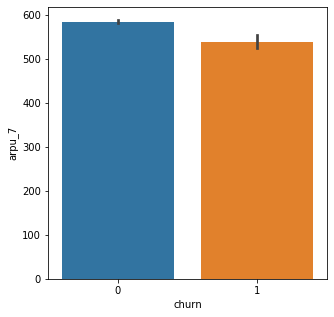

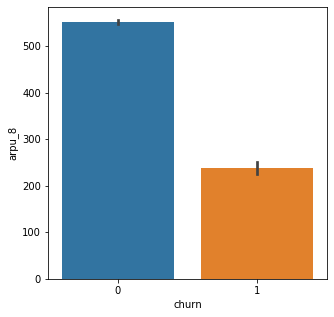

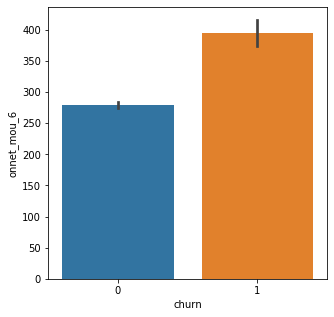

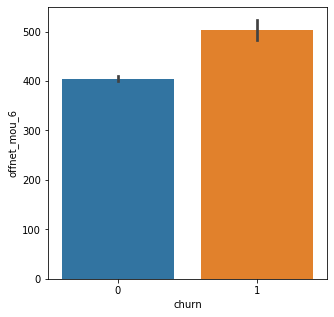

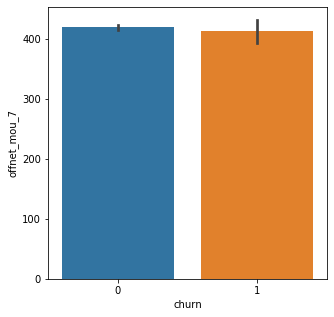

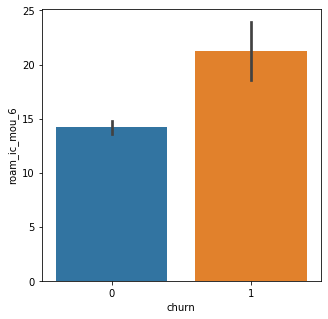

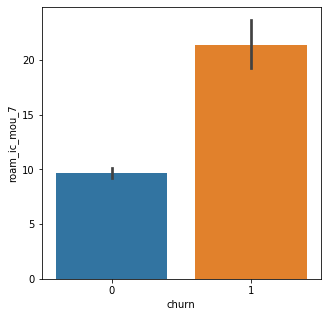

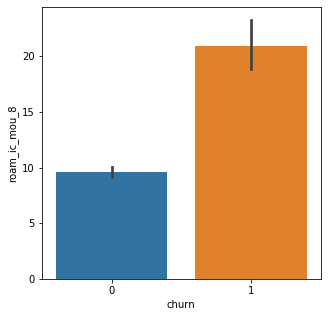

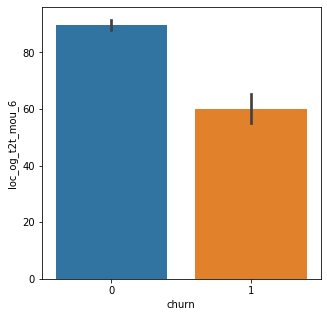

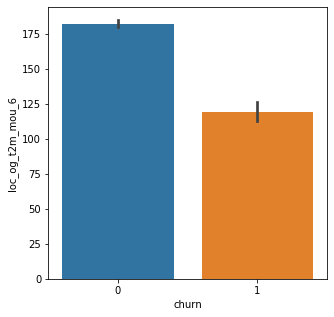

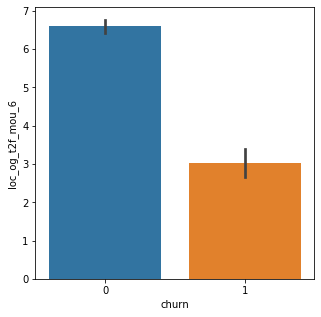

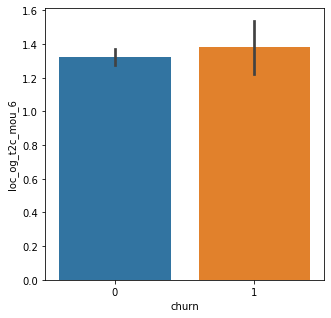

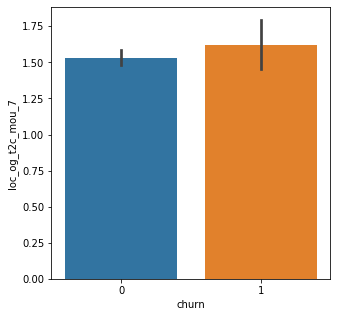

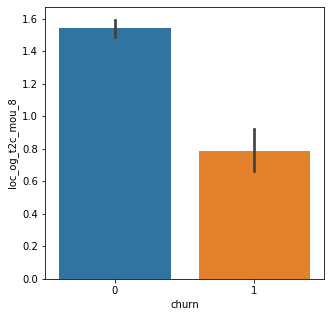

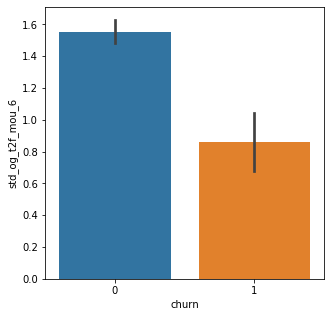

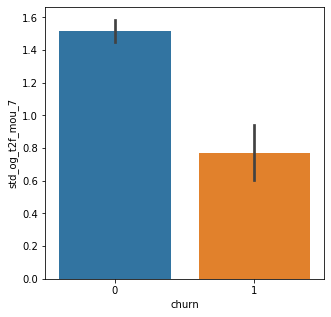

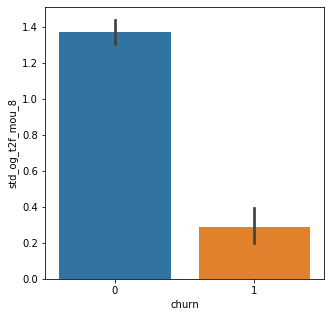

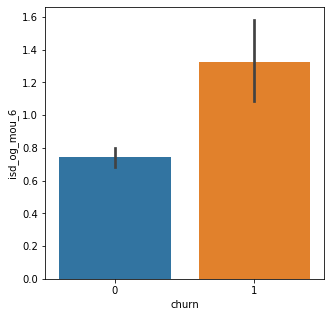

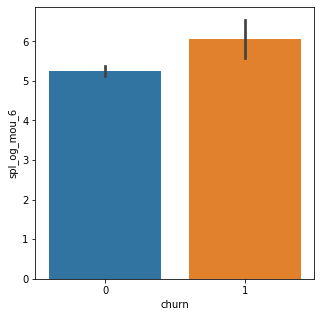

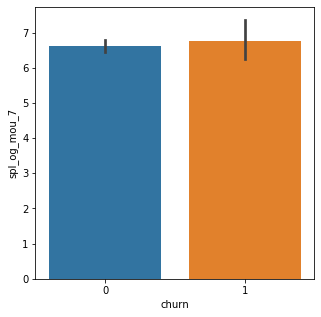

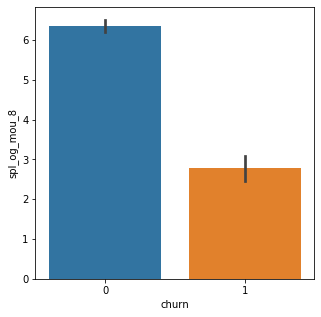

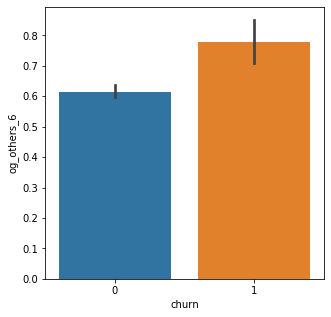

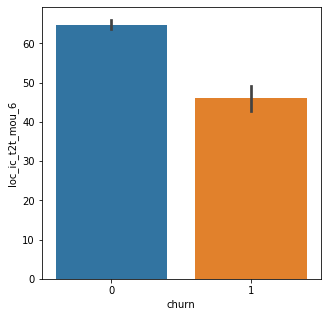

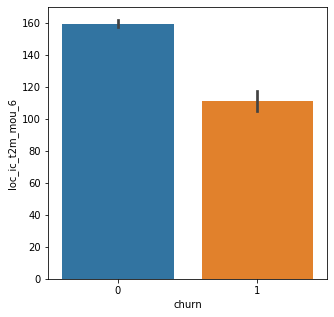

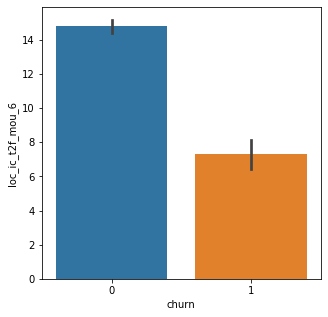

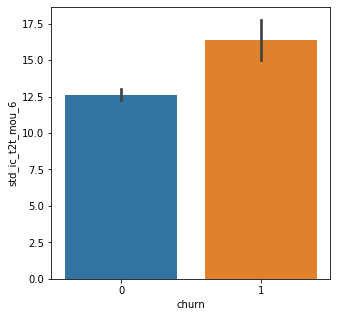

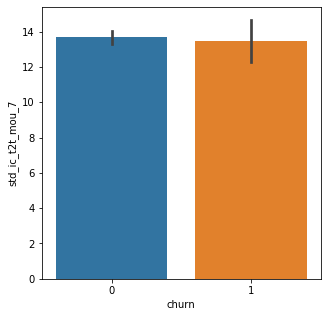

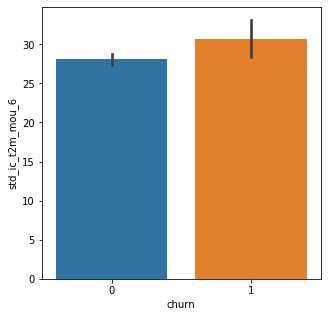

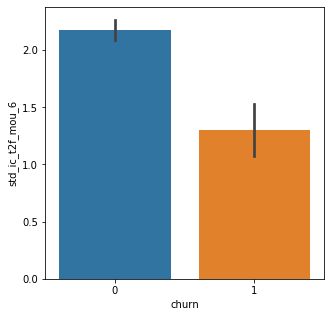

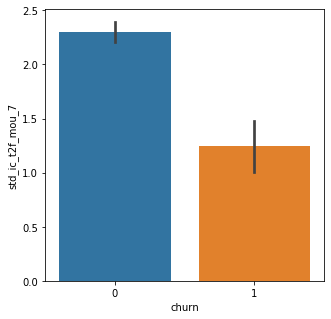

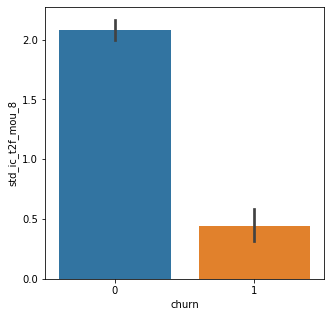

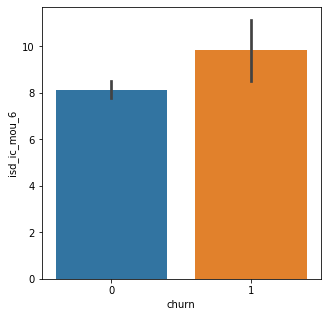

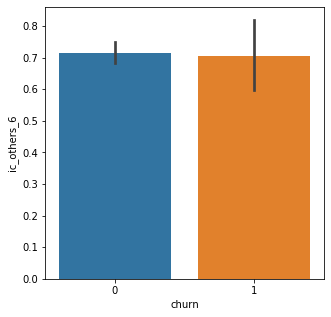

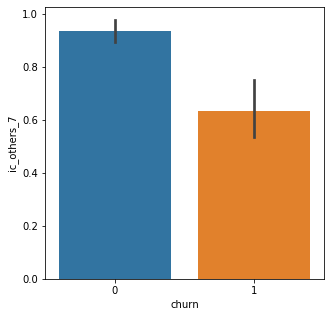

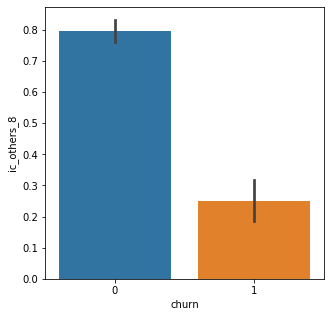

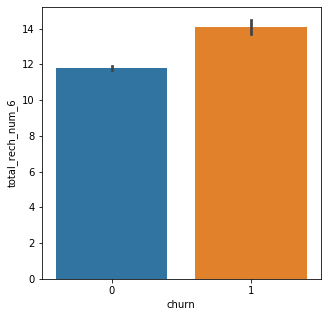

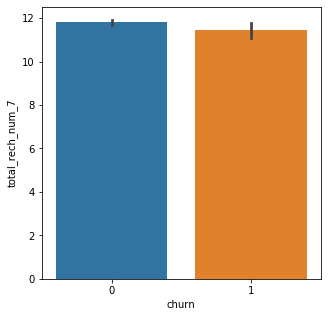

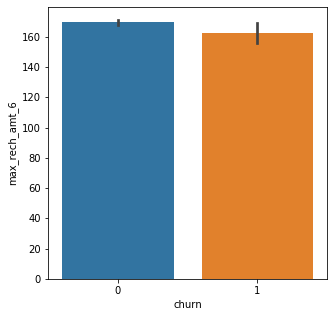

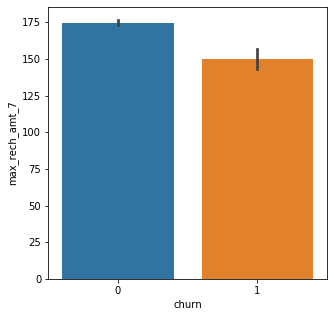

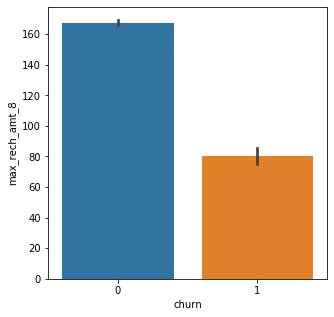

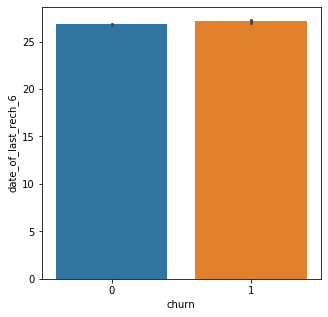

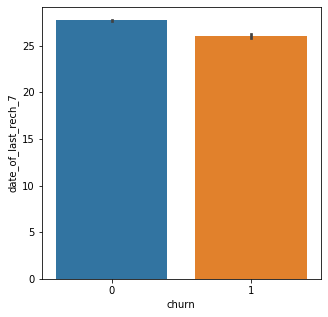

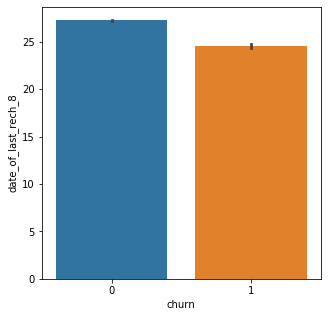

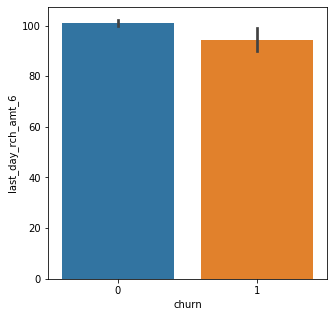

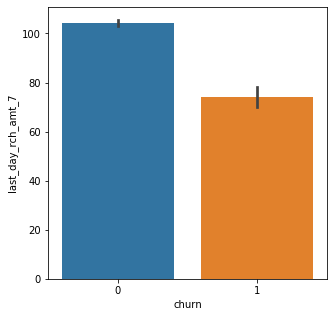

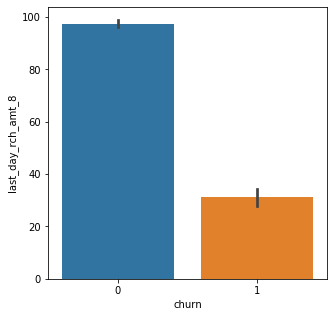

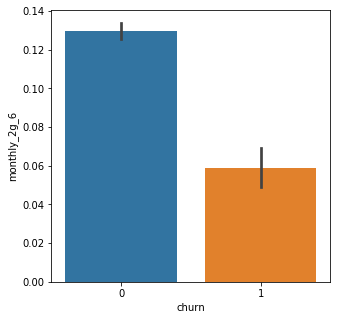

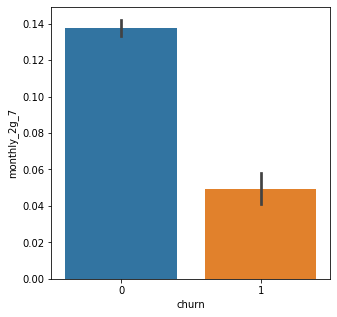

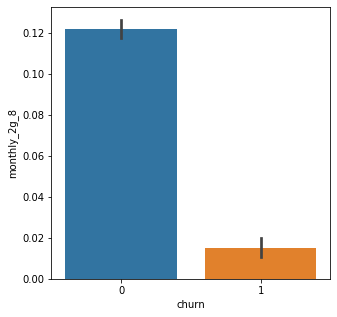

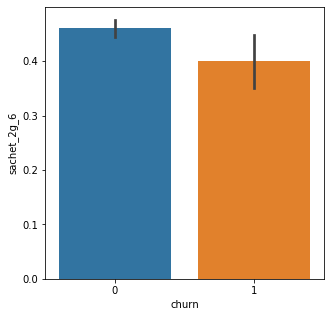

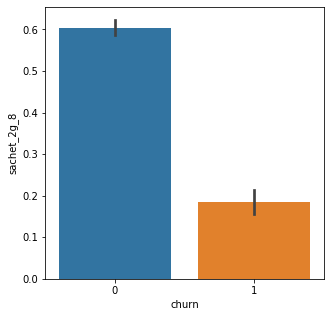

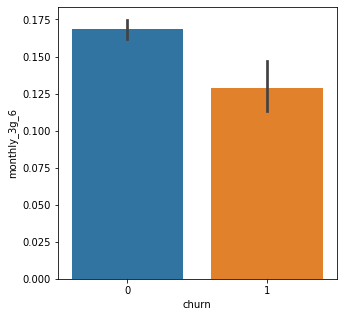

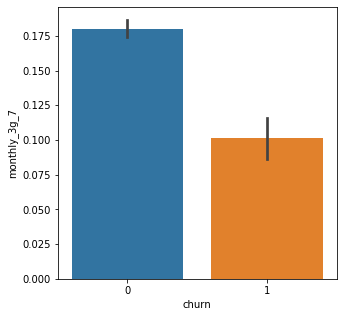

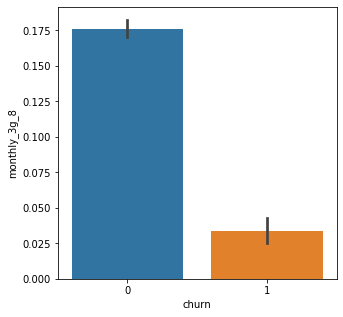

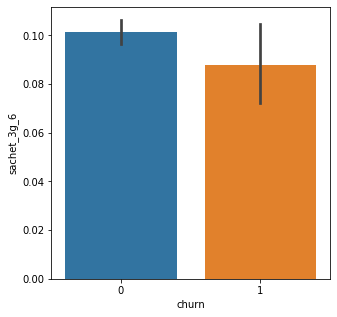

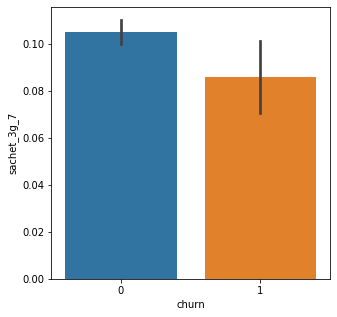

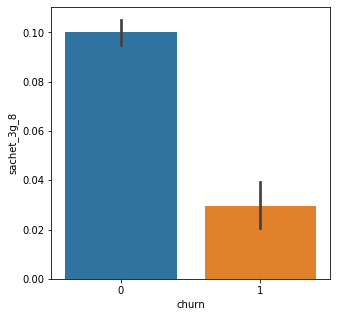

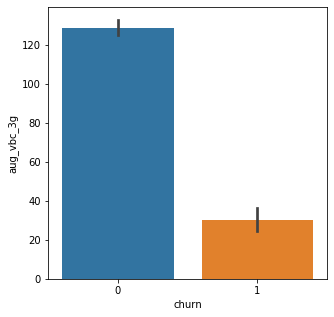

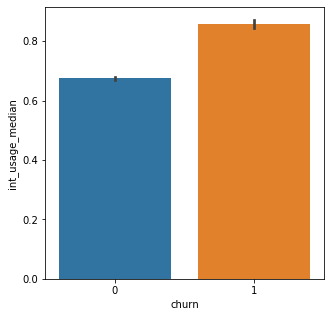

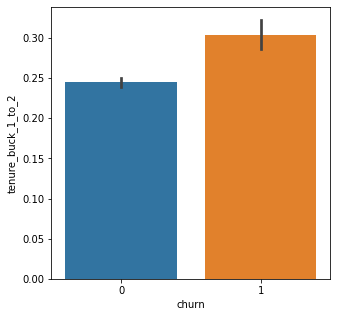

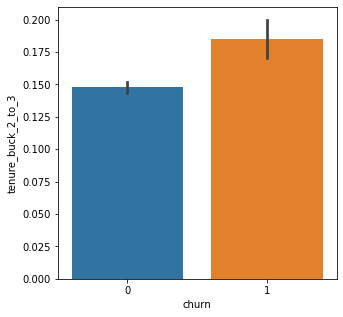

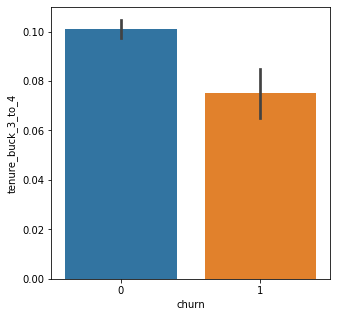

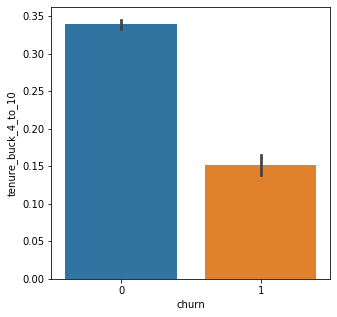

In [33]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='churn', y=col, data=telecom_df4)
    plt.show()

[Text(0, 0.5, '(%)')]

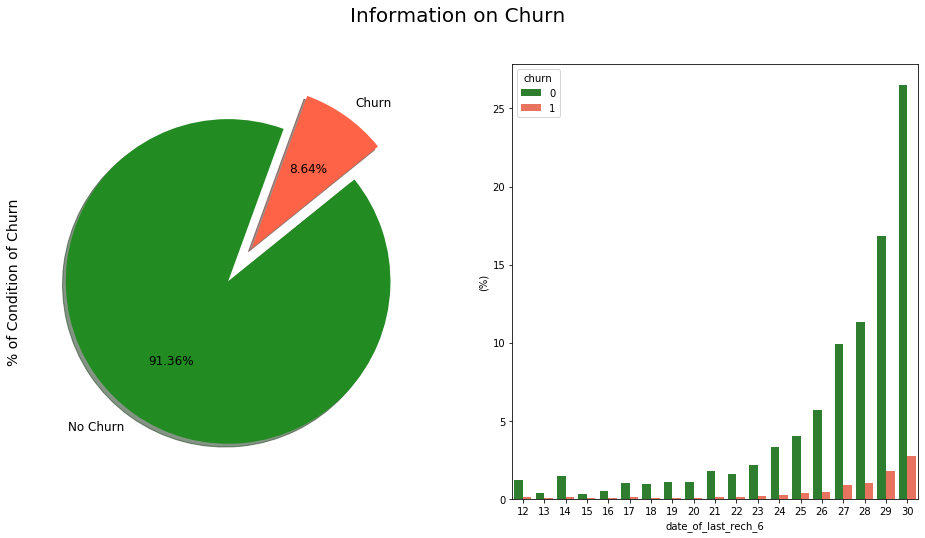

In [34]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#228B22", "#FF6347"]

labels ="No Churn", "Churn"
plt.suptitle('Information on Churn', fontsize=20)

telecom_df4["churn"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Churn', fontsize=14)

palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_6", y="churn", hue="churn", data=telecom_df4, palette=palette, estimator=lambda x: len(x) / len(telecom_df4) * 100)
ax[1].set(ylabel="(%)")

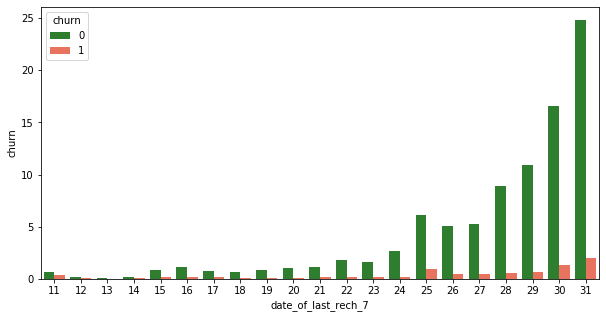

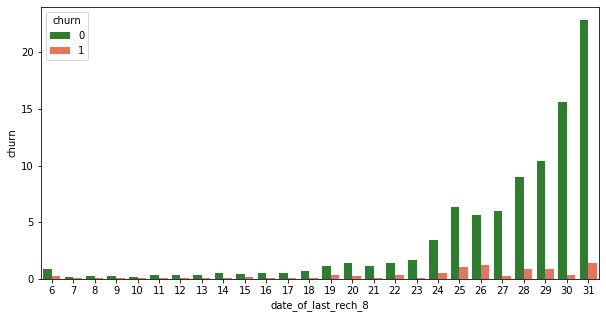

In [35]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_7", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

In [36]:
telecom_df4.shape

(29979, 66)

In [37]:
telecom_df5 = telecom_df4
telecom_df5.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,churn,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,7000701601,1069.180,1349.8500,1988.08226,57.84,453.43,567.160,16.23,33.49,31.64,...,0,0,0,57.74,1,1,0,1,0,0
8,7001524846,378.721,492.2230,137.36200,413.69,94.66,80.630,0.00,0.00,0.00,...,0,0,0,21.03,0,0,0,0,0,0
13,7002191713,492.846,205.6710,593.26000,501.76,413.31,119.280,23.53,144.24,72.11,...,0,0,0,0.00,0,1,0,0,0,1
16,7000875565,430.975,299.8690,187.89400,50.51,296.29,229.740,0.00,2.83,0.00,...,0,0,0,0.00,0,1,1,0,0,0
17,7000187447,690.008,25.6006,25.49900,1185.91,61.64,1.099,0.00,4.76,4.81,...,0,0,0,0.00,0,1,1,0,0,0


### Model Building

Splitting Data into Training and Test Sets

In [38]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_df5.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_df5['churn']

# defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                          
# applying normalize ( ) to all columns 
#X_norm = X.apply(normalize) 
#X_norm.head()

In [39]:
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    return X_scale_final

In [40]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

(29979, 64)


,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
0,1.461367,2.276535,3.946965,-0.571433,0.095390,0.346603,0.027543,0.559940,0.521005,-0.222661,...,-0.324192,-0.234617,-0.233161,-0.217991,-0.196901,0.668791,-0.576901,2.370207,-0.331111,-0.690611
1,-0.593383,-0.259350,-1.044433,0.308581,-0.758761,-0.787053,-0.289063,-0.261011,-0.262426,1.313639,...,-0.324192,-0.234617,-0.233161,-0.217991,-0.312131,-1.495234,-0.576901,-0.421904,-0.331111,-0.690611
2,-0.253756,-1.106645,0.185125,0.526377,-0.000126,-0.696995,0.169947,3.274791,1.523073,-0.233664,...,-0.324192,-0.234617,-0.233161,-0.217991,-0.378142,0.668791,-0.576901,-0.421904,-0.331111,1.447993
3,-0.437879,-0.828114,-0.908148,-0.589560,-0.278725,-0.439614,-0.289063,-0.191639,-0.262426,-0.277551,...,-0.324192,-0.234617,-0.233161,-0.217991,-0.378142,0.668791,1.733400,-0.421904,-0.331111,-0.690611
4,0.332982,-1.639088,-1.346128,2.218274,-0.837374,-0.972367,-0.289063,-0.144328,-0.143326,-0.300182,...,-0.324192,-0.234617,-0.233161,-0.217991,-0.378142,0.668791,1.733400,-0.421904,-0.331111,-0.690611


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7,test_size=0.3,random_state=100)

In [42]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1774
Before OverSampling, counts of label '0': 19211 



In [43]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_test==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_test==0)))

Before OverSampling, counts of label '1': 815
Before OverSampling, counts of label '0': 8179 



### PCA

In [44]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [45]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [46]:
print(pca.components_)
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':colnames})
pcs_df.head(10)

[[ 1.19637143e-01  1.33185807e-01  1.52008696e-01 ... -3.56332584e-02
  -6.28707925e-03  1.24833937e-01]
 [ 2.97495628e-01  3.08059194e-01  2.71938422e-01 ...  2.26685273e-02
  -3.71111087e-03 -6.02687207e-02]
 [-6.10563083e-02 -1.08194427e-02  1.65712444e-02 ... -2.14164988e-03
   4.19474138e-03 -4.54567650e-02]
 ...
 [ 3.41449317e-01  4.63462779e-01 -4.06440564e-01 ... -3.23288601e-02
  -3.32089728e-02 -5.17610711e-02]
 [ 7.11830266e-02  1.37203838e-01 -4.51592294e-02 ...  1.59984586e-02
   7.74492196e-03  9.19564065e-03]
 [-5.67201147e-01  4.27843454e-01  1.42476161e-02 ...  3.42476717e-04
   7.62349294e-03  1.35377425e-02]]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Feature
0,0.119637,0.297496,-0.061056,-0.168625,-0.093462,-0.057189,0.016542,0.043329,0.081248,-0.074202,arpu_6
1,0.133186,0.308059,-0.010819,-0.178049,0.012759,-0.099149,0.063389,-0.137193,-0.044073,0.058336,arpu_7
2,0.152009,0.271938,0.016571,-0.141856,-0.001398,-0.081814,0.065685,-0.131990,-0.055701,0.067627,arpu_8
3,-0.056727,0.123805,-0.090462,-0.110922,0.025098,-0.019090,0.021952,0.164731,0.295252,-0.223859,onnet_mou_6
4,0.024215,0.231150,-0.203379,-0.157557,-0.119148,0.014894,-0.000311,-0.127613,-0.150692,0.044048,offnet_mou_6
5,0.023735,0.230026,-0.175433,-0.164279,-0.033712,-0.012013,0.036760,-0.229885,-0.221348,0.125264,offnet_mou_7
6,0.040966,0.020448,-0.021007,-0.086484,0.156904,-0.189211,0.177065,0.040360,-0.153189,-0.222312,roam_ic_mou_6
7,0.046980,0.024700,-0.032743,-0.088498,0.140752,-0.197751,0.187746,0.074001,-0.147446,-0.291064,roam_ic_mou_7
8,0.049969,0.044368,-0.032821,-0.083138,0.123200,-0.184978,0.182923,0.072739,-0.139099,-0.257126,roam_ic_mou_8
9,0.049123,0.096960,-0.071065,-0.021475,-0.216890,0.106873,-0.086966,0.139108,0.232572,-0.257581,loc_og_t2t_mou_6


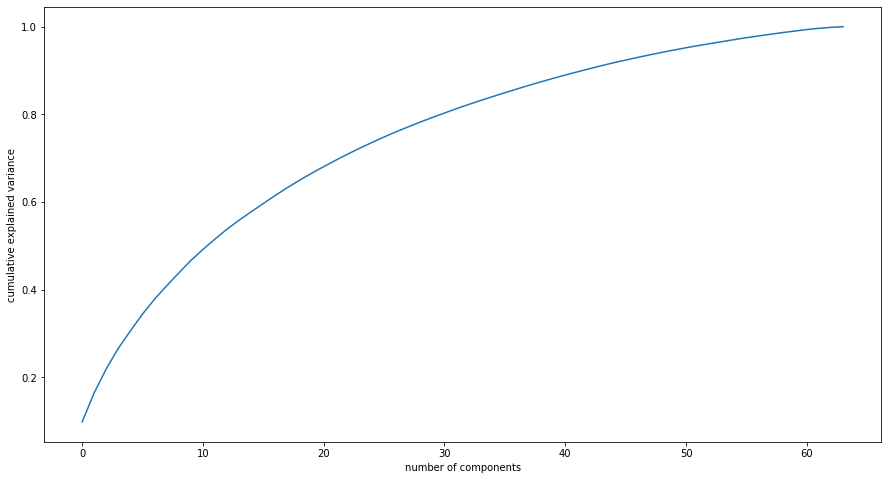

In [47]:
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

As we can see 45 component explain 90% of variance in the data

In [48]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=45)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(20985, 45)

#### Correlation matrix

In [49]:
corrmat = np.corrcoef(df_train_pca.transpose())

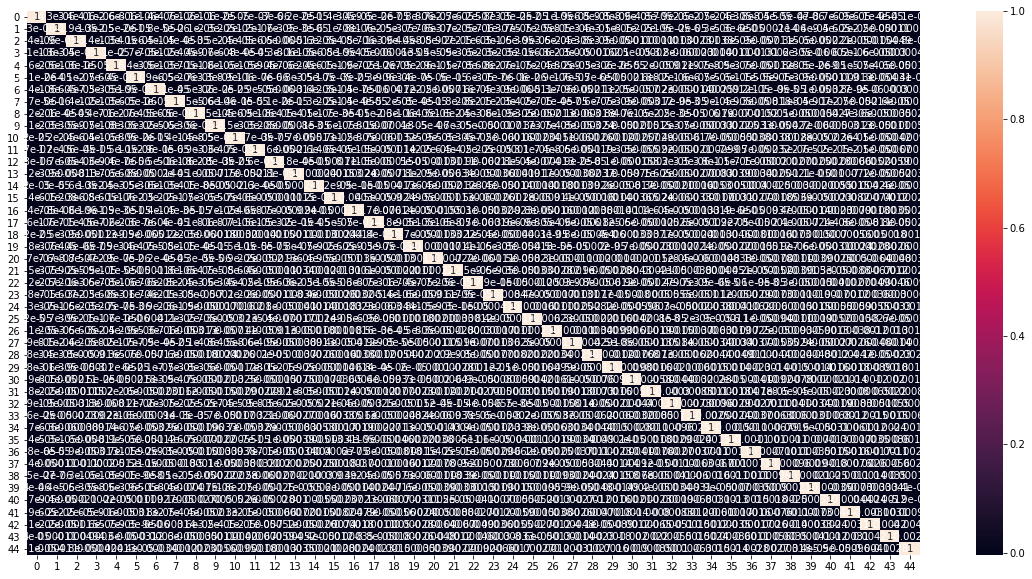

In [50]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [51]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.0042127183667705305 , min corr:  -0.0041100757114640165


In [52]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 45)

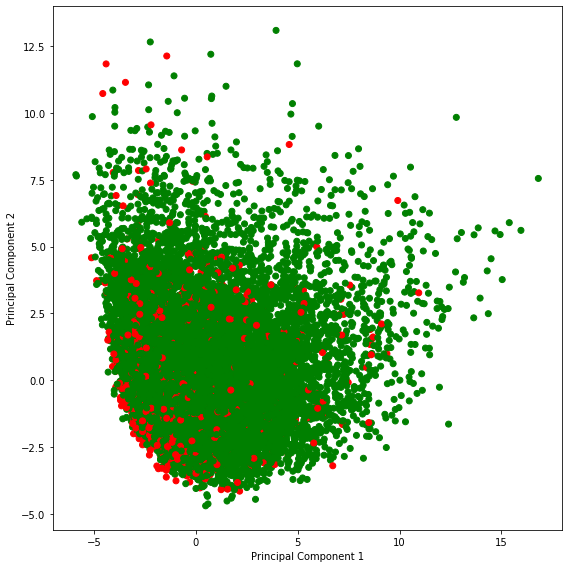

In [53]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

### LogisticRegression model with PCA
Now lets do the modeling with selected 45 pca feature
We also needs to do the class imbalance with class_width = balanced

In [54]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

In [55]:
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.86'

In [56]:
#Making prediction on the test data
pred_test = model_pca.predict_proba(df_test_pca)
y_pred_default = model_pca.predict(df_test_pca)

In [57]:
# print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[6688 1491]
 [ 172  643]]
0.8150989548587948


In [58]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [59]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8645290160271291


### ROC Curve

In [60]:
#ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

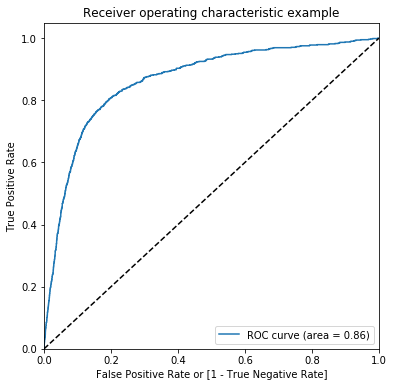

(array([0.        , 0.        , 0.        , ..., 0.99975547, 0.99987774,
        1.        ]),
 array([0.        , 0.00122699, 0.00245399, ..., 1.        , 1.        ,
        1.        ]),
 array([1.99824001e+00, 9.98240008e-01, 9.94448392e-01, ...,
        1.29316369e-04, 5.45748724e-05, 2.00721440e-05]))

In [61]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [62]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.058449,1,0,0,0,0,0,0,0,0,0
1,0,0.119359,1,1,0,0,0,0,0,0,0,0
2,0,0.098985,1,0,0,0,0,0,0,0,0,0
3,0,0.398179,1,1,1,1,0,0,0,0,0,0
4,0,0.555687,1,1,1,1,1,1,0,0,0,0


In [63]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.317990  0.252965  0.970552
0.2   0.2  0.494441  0.449321  0.947239
0.3   0.3  0.625306  0.597628  0.903067
0.4   0.4  0.738381  0.726861  0.853988
0.5   0.5  0.815099  0.817704  0.788957
0.6   0.6  0.862130  0.876513  0.717791
0.7   0.7  0.887036  0.916249  0.593865
0.8   0.8  0.903158  0.949994  0.433129
0.9   0.9  0.908495  0.977014  0.220859


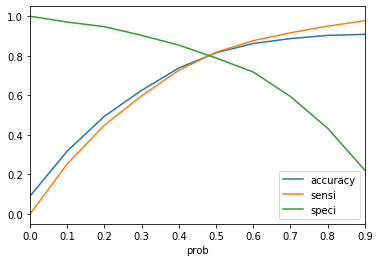

In [64]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [65]:
## Finidng the optimal cutoff
import sys
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.48181295858298573]


In [66]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    8179
1     815
Name: churn, dtype: int64

### Confusion matrix

In [67]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6633, 1546],
       [ 165,  650]], dtype=int64)

### Logistic Regression model matrics wit PCA -

In [68]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.8150989548587948
Sensitivity:  0.7975460122699386
Specificity:  0.8109793373273017
false postive rate:  0.18902066267269838
positive predictive value:  0.2959927140255009
Negative predictive value:  0.9757281553398058
Misclassification Rate:  0.1902379364020458


### LogistcRegression model with RFE

As we have seen with PCA we select 45 component.
We are selecting 10 feature from RFE

In [71]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 40 variables as output as PCA gave 40
rfe = rfe.fit(X_scaled,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[ True  True  True False False False False False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True False
 False  True False  True False False  True False False False False False
 False False False False]
[ 1  1  1 25 24 55 30 29  1  9  1  8 39 46 31 26 36 12 35 51 32  4 50 38
 54 19 41 42 40 49 34  3 17 53 47 11 45 44 23  7 52 28  5  1 37 18  1 27
 43  1 22  1 33 16  1 48 14 13  6 15 20 21 10  2]


In [72]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_7', 'arpu_8', 'roam_ic_mou_8', 'loc_og_t2m_mou_6',
       'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8'],
      dtype='object')

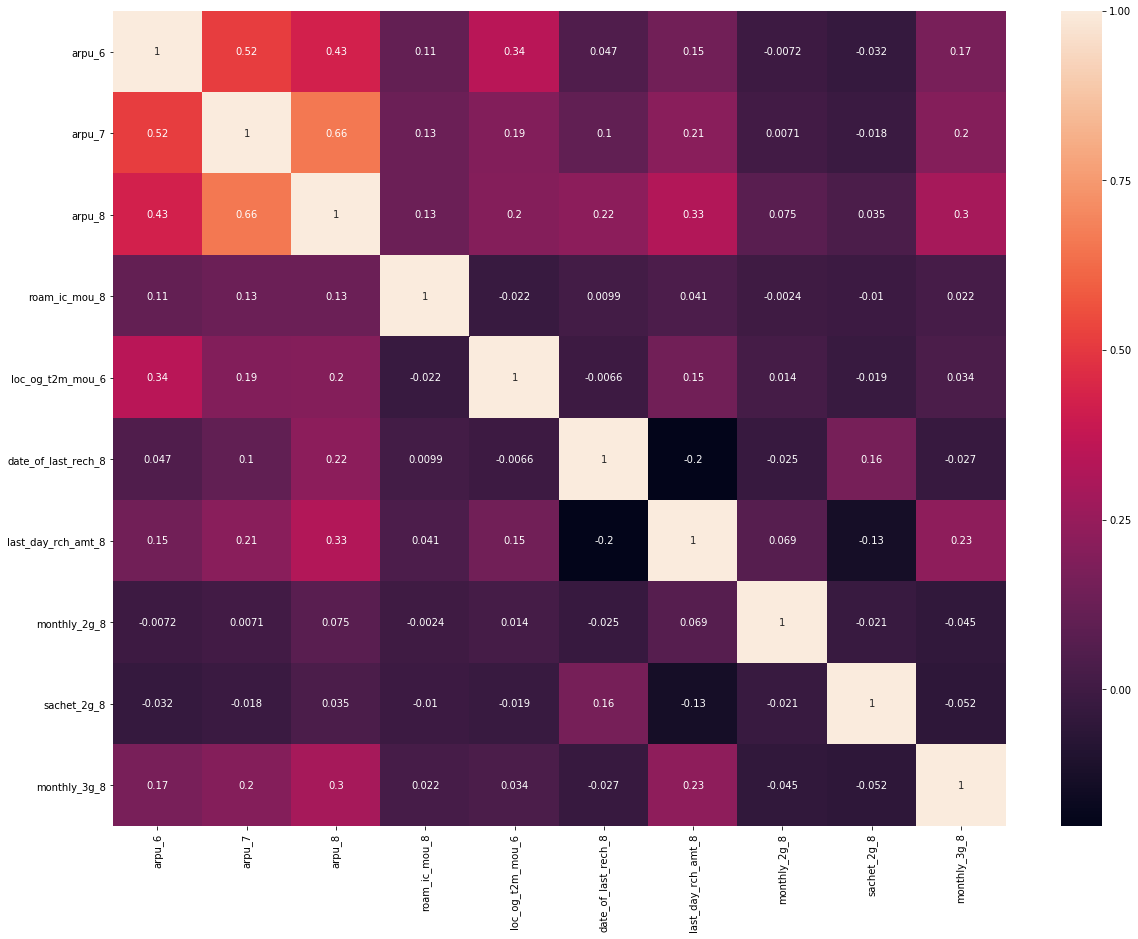

In [73]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,15))        # Size of the figure
sns.heatmap(X_scaled[col].corr(),annot = True)

In [74]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [76]:
col_for_vif = list(col)
col_for_vif.append('churn')
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

,Var,Vif
1,arpu_7,7.78
2,arpu_8,6.24
0,arpu_6,5.86
5,date_of_last_rech_8,5.15
4,loc_og_t2m_mou_6,1.95
6,last_day_rch_amt_8,1.94
9,monthly_3g_8,1.26
8,sachet_2g_8,1.19
7,monthly_2g_8,1.12
3,roam_ic_mou_8,1.10


In [77]:
col_for_vif.remove('arpu_7')
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

,Var,Vif
0,arpu_6,5.09
4,date_of_last_rech_8,4.81
1,arpu_8,4.57
3,loc_og_t2m_mou_6,1.95
5,last_day_rch_amt_8,1.94
8,monthly_3g_8,1.26
7,sachet_2g_8,1.19
6,monthly_2g_8,1.12
2,roam_ic_mou_8,1.10


In [78]:
col_for_vif.remove('arpu_6')
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

,Var,Vif
0,arpu_8,4.12
3,date_of_last_rech_8,3.69
4,last_day_rch_amt_8,1.93
2,loc_og_t2m_mou_6,1.76
7,monthly_3g_8,1.25
6,sachet_2g_8,1.18
5,monthly_2g_8,1.12
1,roam_ic_mou_8,1.09


In [79]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='balanced')
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### ROC_AUC score

In [80]:
#Making prediction on the test data
pred_probs_test = logsk.predict_proba(X_test[col])[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.86'

In [81]:
#Making prediction on the test data
pred_test = logsk.predict_proba(X_test[col])
y_pred_default = logsk.predict(X_test[col])

In [82]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score : ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8179
           1       0.30      0.80      0.44       815

    accuracy                           0.81      8994
   macro avg       0.64      0.81      0.66      8994
weighted avg       0.92      0.81      0.85      8994

[[6643 1536]
 [ 159  656]]
accuracy_score :  0.8115410273515677


In [83]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})

In [84]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC Score: ',roc_auc)

ROC_AUC Score:  0.8642888378662399


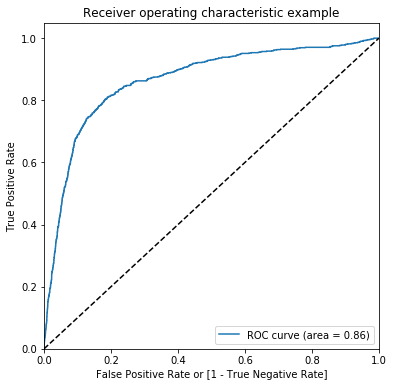

(array([0.00000000e+00, 1.22264335e-04, 1.22264335e-04, ...,
        9.99755471e-01, 9.99877736e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.00122699, ..., 1.        , 1.        ,
        1.        ]),
 array([1.99865909e+00, 9.98659088e-01, 9.96773880e-01, ...,
        2.78949247e-05, 2.51302219e-05, 7.52137838e-06]))

In [85]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [86]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.039017,1,0,0,0,0,0,0,0,0,0
1,0,0.147866,1,1,0,0,0,0,0,0,0,0
2,0,0.333209,1,1,1,1,0,0,0,0,0,0
3,0,0.141048,1,1,0,0,0,0,0,0,0,0
4,0,0.508363,1,1,1,1,1,1,0,0,0,0


In [87]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.301757  0.235237  0.969325
0.2   0.2  0.462642  0.414232  0.948466
0.3   0.3  0.604848  0.574765  0.906748
0.4   0.4  0.728374  0.715002  0.862577
0.5   0.5  0.811541  0.812202  0.804908
0.6   0.6  0.862130  0.874801  0.734969
0.7   0.7  0.890149  0.916860  0.622086
0.8   0.8  0.905715  0.954395  0.417178
0.9   0.9  0.910718  0.983005  0.185276


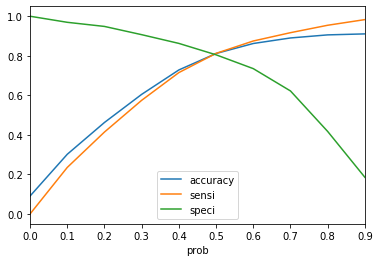

In [88]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [89]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    8179
1     815
Name: churn, dtype: int64

In [90]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6587, 1592],
       [ 153,  662]], dtype=int64)

In [91]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score : ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

Accuracy Score :  0.8115410273515677
Sensitivity:  0.8122699386503067
Specificity:  0.8053551778946081
false postive rate:  0.19464482210539186
positive predictive value:  0.2937000887311446
Negative predictive value:  0.977299703264095


##### As we can see Above LogisticRegression giving good Accuracy with PCA and with RFE

#### With PCA:

Accuracy Score on test data:  0.8150989548587948
Sensitivity:  0.7975460122699386
Specificity:  0.8109793373273017
false postive rate:  0.18902066267269838
positive predictive value:  0.2959927140255009
Negative predictive value:  0.9757281553398058
Misclassification Rate:  0.1902379364020458

    
#### With RFE
Accuracy Score :  0.8115410273515677
Sensitivity:  0.8122699386503067
Specificity:  0.8053551778946081
false postive rate:  0.19464482210539186
positive predictive value:  0.2937000887311446
Negative predictive value:  0.977299703264095

### DecisionTreeClassifier With PCA

In [94]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt_default.fit(df_train_pca,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [95]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(df_test_pca)

# from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('Acuracy Score', accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84      8179
           1       0.21      0.67      0.32       815

    accuracy                           0.74      8994
   macro avg       0.58      0.71      0.58      8994
weighted avg       0.89      0.74      0.79      8994

[[6080 2099]
 [ 269  546]]
Acuracy Score 0.736713364465199


In [96]:
confusion_tree = confusion_matrix(y_test,y_pred_default)
TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy Score', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Acuracy Score 0.736713364465199
Sensitivity:  0.6699386503067485
Specificity:  0.7433671597994865
false postive rate:  0.2566328402005135
positive predictive value:  0.2064272211720227
Negative predictive value:  0.9576311230114979
Misclassification Rate:  0.263286635534801


### Hyperparameter tuning

In [97]:
# GridSearchCV to find optimal max_depth
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                    scoring="accuracy",
                    return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             sco

In [98]:
y_train.shape

(20985,)

In [99]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.210937,0.026503,0.002639,0.002029,1,{'max_depth': 1},0.695808,0.759352,0.745771,0.782464,...,0.737479,0.032949,37,0.692083,0.759828,0.765130,0.779366,0.703675,0.740017,0.035185
1,0.434901,0.005379,0.003207,0.002616,2,{'max_depth': 2},0.772749,0.817489,0.815344,0.843460,...,0.809245,0.023467,30,0.774349,0.823207,0.827675,0.836729,0.797427,0.811877,0.022859
2,0.627688,0.006459,0.004632,0.003497,3,{'max_depth': 3},0.666984,0.634739,0.689778,0.707410,...,0.679056,0.025802,39,0.678203,0.647129,0.701156,0.701096,0.689440,0.683405,0.020037
3,0.808389,0.008378,0.002247,0.003522,4,{'max_depth': 4},0.686279,0.704789,0.728854,0.787229,...,0.724232,0.034389,38,0.698934,0.713069,0.745652,0.780915,0.712073,0.730129,0.029700
4,0.933586,0.063548,0.004013,0.003504,5,{'max_depth': 5},0.751787,0.765547,0.703121,0.770789,...,0.746486,0.024044,36,0.759218,0.772993,0.718489,0.777043,0.742986,0.754146,0.021453


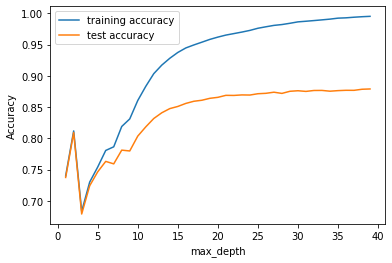

In [100]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# seems 15 or 20 Max depth

In [101]:
## Lets tune min sample leaf
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [103]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.883697,0.085011,0.002534,0.003746,5,{'min_samples_leaf': 5},0.844450,0.843460,0.842507,0.852275,...,0.844603,0.004072,1,0.937988,0.942876,0.938944,0.937157,0.939603,0.939314,0.001966
1,1.627751,0.056504,0.003534,0.004360,25,{'min_samples_leaf': 25},0.792282,0.772695,0.789850,0.786514,...,0.784608,0.006934,2,0.844880,0.828568,0.838575,0.826781,0.833998,0.834561,0.006624
2,1.533871,0.034611,0.001601,0.003203,45,{'min_samples_leaf': 45},0.745355,0.757684,0.744103,0.767215,...,0.752395,0.008818,3,0.782927,0.800751,0.780021,0.783715,0.785872,0.786657,0.007292
3,1.441035,0.035664,0.006713,0.003388,65,{'min_samples_leaf': 65},0.755121,0.748153,0.733619,0.765785,...,0.748678,0.011178,5,0.776911,0.778473,0.770491,0.782404,0.766573,0.774970,0.005690
4,1.399285,0.029732,0.003402,0.003776,85,{'min_samples_leaf': 85},0.771081,0.757208,0.737193,0.762688,...,0.751918,0.015156,4,0.787752,0.786157,0.759888,0.772516,0.743701,0.770003,0.016592


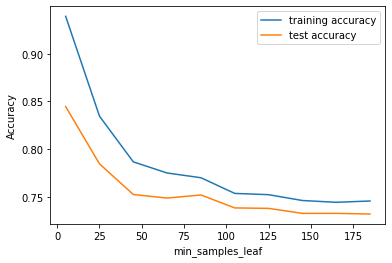

In [104]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [105]:
## Tuning min sample split
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [106]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.070270,0.053704,0.005134,0.001194,5,{'min_samples_split': 5},0.875179,0.879438,0.872051,0.879914,...,0.875721,0.003431,1,0.994996,0.996307,0.993209,0.995175,0.994520,0.994842,0.001005
1,2.027037,0.054047,0.004657,0.003141,25,{'min_samples_split': 25},0.835398,0.835597,0.827734,0.846319,...,0.835692,0.006026,2,0.933043,0.932511,0.928878,0.934596,0.936446,0.933095,0.002515
2,1.954454,0.059646,0.005874,0.003861,45,{'min_samples_split': 45},0.803954,0.804622,0.807958,0.808911,...,0.806814,0.002097,3,0.891166,0.887300,0.893912,0.883012,0.895348,0.890148,0.004501
3,1.941827,0.048197,0.002642,0.002876,65,{'min_samples_split': 65},0.788709,0.787229,0.782464,0.782464,...,0.785895,0.002850,4,0.861857,0.858470,0.856505,0.839707,0.858777,0.855063,0.007867
4,1.910810,0.036048,0.000000,0.000000,85,{'min_samples_split': 85},0.774178,0.785799,0.769359,0.777222,...,0.775602,0.005742,5,0.843986,0.850608,0.832440,0.827198,0.835666,0.837980,0.008341


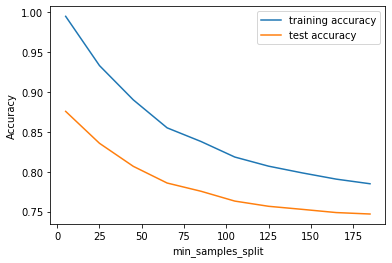

In [107]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [108]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 200, 20),
    'min_samples_split': range(5, 200, 20),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, refit='recall_score',
                          cv = n_folds, verbose = 1, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(df_train_pca,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                  

In [109]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.445773,0.018734,0.006037,0.005149,entropy,5,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715579,0.771980,0.74315,0.783655,0.685891,0.740052,0.035950,155
1,2.453035,0.031539,0.001600,0.003200,entropy,5,5,25,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715579,0.771980,0.74315,0.783655,0.685891,0.740052,0.035950,155
2,2.469220,0.008329,0.004831,0.004025,entropy,5,5,45,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715579,0.772933,0.74315,0.783655,0.685891,0.740243,0.036121,142
3,2.418874,0.034008,0.006528,0.003265,entropy,5,5,65,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715102,0.772933,0.74315,0.782940,0.685891,0.740005,0.036015,157
4,2.455083,0.024678,0.004144,0.005096,entropy,5,5,85,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715102,0.772933,0.74315,0.783417,0.685891,0.740100,0.036129,144


In [110]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.7917083631165118
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [111]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf_gini.fit(df_train_pca,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [112]:
y_pred_default = clf_gini.predict(df_test_pca)
confusion_tree_hyper=confusion_matrix(y_test,y_pred_default)
confusion_tree_hyper

array([[6578, 1601],
       [ 315,  500]], dtype=int64)

In [113]:
TP = confusion_tree_hyper[1,1] # true positive 
TN = confusion_tree_hyper[0,0] # true negatives
FP = confusion_tree_hyper[0,1] # false positives
FN = confusion_tree_hyper[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.6134969325153374
Specificity:  0.8042547988751682
false postive rate:  0.19574520112483187
positive predictive value:  0.23798191337458352
Negative predictive value:  0.9543014652546061
Misclassification Rate:  0.21303090949521902


### RandomForestClassifier with PCA

In [114]:
# Random forest
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

# fit
rfc.fit(df_train_pca,y_train)

# Making predictions
y_pred_default = rfc.predict(df_test_pca)

In [115]:
confusion_rf=confusion_matrix(y_test,y_pred_default)
confusion_rf

array([[8138,   41],
       [ 747,   68]], dtype=int64)

In [116]:
TN = confusion_rf[0,0] # true positive 
TP = confusion_rf[1,1] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.0834355828220859
Specificity:  0.9949871622447732
false postive rate:  0.0050128377552268
positive predictive value:  0.6238532110091743
Negative predictive value:  0.9159257175014068
Misclassification Rate:  0.08761396486546587


### Hyperparameter tuning for RandomForest

In [117]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf_with_pca = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf_with_pca = GridSearchCV(rf_with_pca, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", 
                   return_train_score=True,
                   n_jobs=-1)
rf_with_pca.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [118]:
# scores of GridSearch CV
scores = rf_with_pca.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.806620,0.157255,0.032700,0.008074,2,{'max_depth': 2},0.763935,0.741005,0.777460,0.741482,...,0.745342,0.025375,4,0.762257,0.745175,0.796640,0.738146,0.703199,0.749083,0.030579
1,2.112604,0.348153,0.040638,0.031823,7,{'max_depth': 7},0.837542,0.859423,0.858947,0.856326,...,0.855421,0.009363,3,0.874129,0.885156,0.886645,0.884024,0.888379,0.883667,0.004988
2,2.565440,0.217635,0.022155,0.004854,12,{'max_depth': 12},0.907575,0.901120,0.909221,0.910412,...,0.906600,0.003350,2,0.965032,0.961699,0.964379,0.962711,0.961463,0.963057,0.001425
3,2.147985,0.173515,0.015788,0.006185,17,{'max_depth': 17},0.912577,0.916845,0.913748,0.919228,...,0.915845,0.002387,1,0.980818,0.980522,0.979688,0.981654,0.982727,0.981082,0.001035


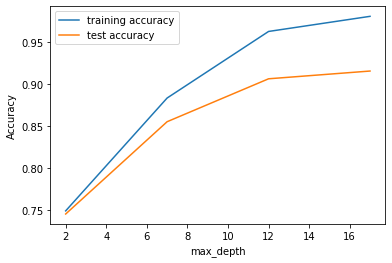

In [119]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [120]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv=n_folds, 
                  scoring="accuracy", 
                  return_train_score=True,
                  n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

In [121]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,20.894554,0.309723,0.218167,0.041236,100,{'n_estimators': 100},0.903525,0.903264,0.916131,0.912557,...,0.909030,0.005036,3,0.959790,0.955385,0.957172,0.953955,0.956817,0.956624,0.001950
1,106.136917,2.494147,0.878000,0.108591,500,{'n_estimators': 500},0.903287,0.904694,0.915416,0.912318,...,0.908697,0.004570,4,0.960207,0.958125,0.958482,0.955683,0.958604,0.958220,0.001457
2,160.512714,17.246839,1.297081,0.349762,900,{'n_estimators': 900},0.903764,0.905647,0.917560,0.914224,...,0.909888,0.005213,2,0.958539,0.958184,0.958899,0.956874,0.958663,0.958232,0.000717
3,172.735188,16.960154,1.257556,0.080629,1300,{'n_estimators': 1300},0.903525,0.907315,0.917560,0.912318,...,0.909983,0.004739,1,0.958599,0.958899,0.958125,0.956636,0.958127,0.958077,0.000779


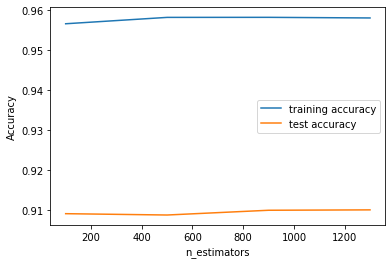

In [122]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [123]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10,class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv=n_folds, 
                  scoring="accuracy",
                  return_train_score=True,
                  n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

In [124]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.342254,0.060920,0.019402,0.003006,4,{'max_features': 4},0.884707,0.893257,0.895640,0.886347,...,0.890017,0.004094,5,0.942217,0.937872,0.943829,0.936264,0.939901,0.940017,0.002759
1,2.169093,0.127265,0.023398,0.005119,8,{'max_features': 8},0.895426,0.885156,0.899929,0.896116,...,0.894401,0.004919,4,0.945255,0.937694,0.943412,0.938170,0.941867,0.941280,0.002940
2,3.892612,0.228813,0.015402,0.001625,14,{'max_features': 14},0.901382,0.895401,0.905409,0.902311,...,0.900929,0.003267,1,0.947102,0.941744,0.945854,0.947760,0.943475,0.945187,0.002259
3,4.966542,0.093123,0.015208,0.001949,20,{'max_features': 20},0.893759,0.895401,0.899452,0.907791,...,0.897355,0.005980,2,0.944362,0.941268,0.943233,0.946569,0.940437,0.943174,0.002194
4,4.877030,0.548386,0.011600,0.001357,24,{'max_features': 24},0.892568,0.895878,0.893734,0.900643,...,0.895687,0.002762,3,0.942396,0.942935,0.940315,0.946569,0.944130,0.943269,0.002061


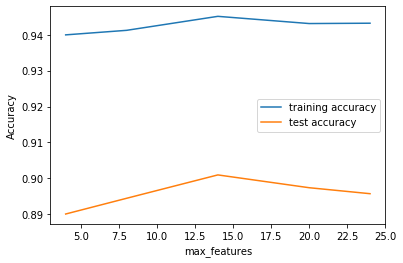

In [125]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [126]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True,n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [127]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.242527,0.039568,0.016157,0.003029,100,{'min_samples_leaf': 100},0.831348,0.832023,0.820586,0.832261,...,0.830498,0.005249,1,0.850837,0.851322,0.839230,0.848761,0.851093,0.848249,0.004601
1,1.114468,0.045652,0.018800,0.011600,150,{'min_samples_leaf': 150},0.821582,0.807720,0.813915,0.823207,...,0.816393,0.005576,2,0.835111,0.831070,0.830057,0.826841,0.820239,0.828664,0.004972
2,1.021935,0.021943,0.014601,0.000800,200,{'min_samples_leaf': 200},0.813721,0.800095,0.800095,0.812723,...,0.804289,0.007553,3,0.822065,0.816178,0.817250,0.812306,0.801954,0.813951,0.006758
3,1.155662,0.112511,0.018002,0.011026,250,{'min_samples_leaf': 250},0.796808,0.800095,0.793186,0.808911,...,0.798999,0.005423,4,0.804194,0.806409,0.803788,0.802835,0.801715,0.803788,0.001565
4,0.927863,0.094983,0.012200,0.000400,300,{'min_samples_leaf': 300},0.803954,0.783893,0.757684,0.796998,...,0.786371,0.015874,5,0.809078,0.794377,0.781868,0.802418,0.797010,0.796950,0.009067


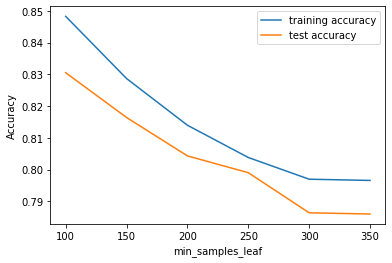

In [128]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [129]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv=n_folds, 
                  scoring="accuracy",
                  return_train_score=True)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [130]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.967321,0.071529,0.010400,0.001357,200,{'min_samples_split': 200},0.859457,0.856088,0.854896,0.859185,...,0.858756,0.003220,1,0.885388,0.881820,0.884680,0.882893,0.885163,0.883989,0.001394
1,0.839305,0.024504,0.009201,0.000400,250,{'min_samples_split': 250},0.846594,0.848940,0.833691,0.848701,...,0.846748,0.007229,2,0.871627,0.875328,0.862819,0.870741,0.870689,0.870241,0.004083
2,0.844688,0.057600,0.009997,0.001099,300,{'min_samples_split': 300},0.844212,0.833691,0.834882,0.848463,...,0.842125,0.006645,3,0.867338,0.852097,0.856326,0.860674,0.861338,0.859555,0.005120
3,0.835893,0.074811,0.009400,0.000491,350,{'min_samples_split': 350},0.825869,0.836788,0.833214,0.846795,...,0.837503,0.007676,4,0.850658,0.853050,0.850250,0.853169,0.865150,0.854455,0.005479
4,0.772092,0.025235,0.009403,0.000491,400,{'min_samples_split': 400},0.817532,0.826543,0.803908,0.841077,...,0.823636,0.012403,5,0.836719,0.841137,0.833095,0.846557,0.841146,0.839731,0.004554


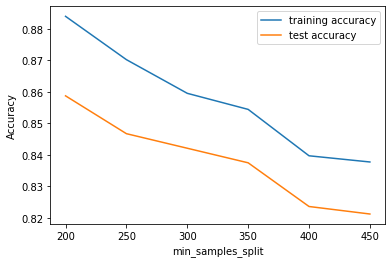

In [131]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [132]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': range(100, 200, 100),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': range(200, 400, 100), 
    'max_features': [8, 10, 12]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1)

In [133]:
# Fit the grid search to the data
grid_search.fit(df_train_pca, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [134]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8527996187753157 using {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [135]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=300)

In [136]:
# fit
rfc.fit(df_train_pca,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=8,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=200, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [137]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score:  ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      8179
           1       0.62      0.08      0.15       815

    accuracy                           0.91      8994
   macro avg       0.77      0.54      0.55      8994
weighted avg       0.89      0.91      0.88      8994

[[8138   41]
 [ 747   68]]
accuracy_score:   0.9123860351345341


In [138]:
# Confusion Matrix
confusion_rf_hyper=confusion_matrix(y_test,y_pred_default)
confusion_rf_hyper

array([[8138,   41],
       [ 747,   68]], dtype=int64)

In [139]:
TN = confusion_rf_hyper[0,0] # true positive 
TP = confusion_rf_hyper[1,1] # true negatives
FP = confusion_rf_hyper[0,1] # false positives
FN = confusion_rf_hyper[1,0] # false negatives

print('Accuracy Score:  ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:   0.9123860351345341
Sensitivity:  0.0834355828220859
Specificity:  0.9949871622447732
false postive rate:  0.0050128377552268
positive predictive value:  0.6238532110091743
Negative predictive value:  0.9159257175014068
Misclassification Rate:  0.08761396486546587


## Recomendation for Model Selection

-Logistic Regression and Random Forest performed better than Decision Tree for customer churn analysis for this particular dataset, using PCA.
-LogisticRegression is the best model 80.9% Sensitivity.
-Accuracy of RandomForest is highest with 91%

LogisticRegression
Accuracy Score : 0.8150989548587948 (With PCA on Test)
Sensitivity:  0.7975460122699386 (with PCA)
Accuracy Score : 0.8115410273515677 (With RFE on Test)
Sensitivity: 0.8122699386503067 (with RFE)

RandomForest
Accuracy Score: 0.9123860351345341
Sensitivity:  0.0834355828220859
Specificity:  0.9949871622447732
    
DecisionTree
Sensitivity: 0.6233128834355828 (with PCA)


### RandomForest on all feature

In [140]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

In [141]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [142]:
# Making predictions
predictions = rfc.predict(X_test)

In [143]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8179
           1       0.78      0.36      0.49       815

    accuracy                           0.93      8994
   macro avg       0.86      0.68      0.73      8994
weighted avg       0.92      0.93      0.92      8994

[[8094   85]
 [ 520  295]]
0.9327329330664887


In [144]:
# Confusion Matrix
confusion_rf_with_all_feature=confusion_matrix(y_test,predictions)
confusion_rf_with_all_feature

array([[8094,   85],
       [ 520,  295]], dtype=int64)

In [145]:
TN = confusion_rf_with_all_feature[0,0] # true positive 
TP = confusion_rf_with_all_feature[1,1] # true negatives
FP = confusion_rf_with_all_feature[0,1] # false positives
FN = confusion_rf_with_all_feature[1,0] # false negatives

print('Accuracy Score: ', accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.9327329330664887
Sensitivity:  0.3619631901840491
Specificity:  0.9896075314830663
false postive rate:  0.01039246851693361
positive predictive value:  0.7763157894736842
Negative predictive value:  0.939633155328535
Misclassification Rate:  0.06726706693351123


### Hyperparameter Tuning

In [146]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True,n_jobs=-1)

In [147]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [148]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.390462,0.018579,0.028174,0.003996,2,{'max_depth': 2},0.857789,0.877770,0.878723,0.895640,...,0.871766,0.016567,4,0.865551,0.884739,0.877412,0.888730,0.844958,0.872278,0.015773
1,0.890997,0.013679,0.021872,0.004869,7,{'max_depth': 7},0.897808,0.893019,0.907791,0.902549,...,0.899833,0.004992,3,0.917496,0.912974,0.913093,0.913212,0.908154,0.912986,0.002958
2,1.306647,0.032632,0.026002,0.001969,12,{'max_depth': 12},0.915912,0.921611,0.934477,0.933047,...,0.926519,0.006980,2,0.957229,0.962235,0.961341,0.960984,0.965037,0.961365,0.002510
3,1.255879,0.095338,0.022184,0.003459,17,{'max_depth': 17},0.927823,0.933524,0.938051,0.935668,...,0.934048,0.003434,1,0.983737,0.981654,0.982607,0.981117,0.979570,0.981737,0.001403


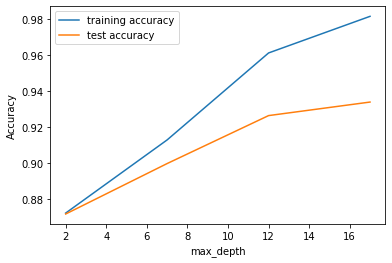

In [149]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [150]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True,n_jobs=-1)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

In [151]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.519922,0.227037,0.203456,0.029660,100,{'n_estimators': 100},0.918771,0.923517,0.934715,0.930665,...,0.926471,0.005599,3,0.954131,0.955802,0.954551,0.954968,0.957055,0.955301,0.001036
1,62.872488,2.302501,0.975532,0.087741,500,{'n_estimators': 500},0.920438,0.925185,0.933047,0.932571,...,0.927901,0.004722,1,0.958241,0.958363,0.956159,0.955861,0.957889,0.957303,0.001071
2,95.820555,8.344115,1.302101,0.105789,900,{'n_estimators': 900},0.920438,0.924946,0.934477,0.930903,...,0.927663,0.004828,2,0.958063,0.957946,0.956814,0.955980,0.957651,0.957291,0.000787


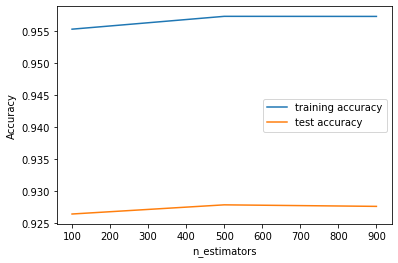

In [152]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [153]:
 # GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

In [154]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.439786,0.029921,0.018130,0.002322,4,{'max_features': 4},0.906622,0.910650,0.921611,0.920419,...,0.916035,0.006187,5,0.940788,0.939957,0.940136,0.939242,0.940914,0.940207,0.000606
1,0.796723,0.014362,0.016176,0.002416,8,{'max_features': 8},0.913768,0.913033,0.926614,0.920181,...,0.919133,0.005132,4,0.948174,0.951156,0.946807,0.945080,0.950682,0.948380,0.002298
2,1.308287,0.017092,0.017874,0.005601,14,{'max_features': 14},0.909719,0.918990,0.928520,0.923040,...,0.920896,0.006361,3,0.947281,0.955385,0.950322,0.951751,0.954911,0.951930,0.003002
3,1.848888,0.024912,0.016073,0.002276,20,{'max_features': 20},0.914721,0.920181,0.929950,0.924232,...,0.923136,0.005276,1,0.952999,0.957648,0.953598,0.951453,0.955268,0.954193,0.002116
4,2.186076,0.024279,0.017773,0.001101,24,{'max_features': 24},0.916865,0.920658,0.924470,0.923755,...,0.921658,0.002723,2,0.954965,0.956159,0.946629,0.951453,0.951575,0.952156,0.003326


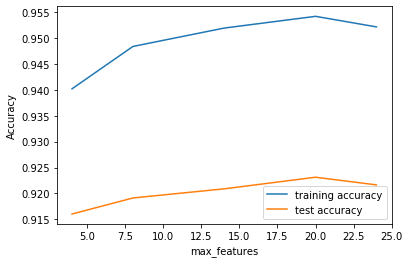

In [155]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(150, 250, 50),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': [300,400,500], 
    'max_features': [15, 20]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 3, verbose = 1, n_jobs=-1)

In [157]:
# fit
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 17.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [158]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.874481772694782 using {'max_depth': 12, 'max_features': 15, 'min_samples_leaf': 150, 'min_samples_split': 200, 'n_estimators': 300}


In [159]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=150, 
                             min_samples_split=300,
                             max_features=15,
                             n_estimators=500)

In [160]:
# fit
rfc_final.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=15,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=150,
                       min_samples_split=300, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [161]:
from sklearn import metrics
confusion_rm_f = metrics.confusion_matrix( y_test, predictions )
confusion_rm_f

array([[8094,   85],
       [ 520,  295]], dtype=int64)

In [162]:
TN = confusion_rm_f[0,0] # true positive 
TP = confusion_rm_f[1,1] # true negatives
FP = confusion_rm_f[0,1] # false positives
FN = confusion_rm_f[1,0] # false negatives

print('Accuracy Score: ',accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.9327329330664887
Sensitivity:  0.3619631901840491
Specificity:  0.9896075314830663
false postive rate:  0.01039246851693361
positive predictive value:  0.7763157894736842
Negative predictive value:  0.939633155328535
Misclassification Rate:  0.06726706693351123


#####  RandomForest model with All feature gives:
93% of Accuracy and 36% of Sensitivity

In [163]:
#Important Variables
from collections import OrderedDict
feature_names=list(X_train.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance
#Sorting Dictionary in descending order of the importance variable
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [164]:
telecom_df5.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'isd_ic_mou_6', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6',
       'mont

In [165]:
#Variable Importance top 30 variable
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=12
n_items = take(n, dic.items())

In [166]:
print('These are top 12 driver variable: ',n_items)

These are top 12 driver variable:  [('arpu_8', 0.25483354911020023), ('last_day_rch_amt_8', 0.2002829775544457), ('roam_ic_mou_8', 0.13338886795825416), ('max_rech_amt_8', 0.11157225513611138), ('date_of_last_rech_8', 0.07819890381618859), ('spl_og_mou_8', 0.03232059484999482), ('std_ic_t2f_mou_8', 0.020992267374913446), ('roam_ic_mou_7', 0.01413795580740539), ('loc_og_t2f_mou_6', 0.012812263425400296), ('arpu_7', 0.011285920410764592), ('ic_others_8', 0.010361689266017658), ('loc_ic_t2f_mou_6', 0.010184030098070788)]


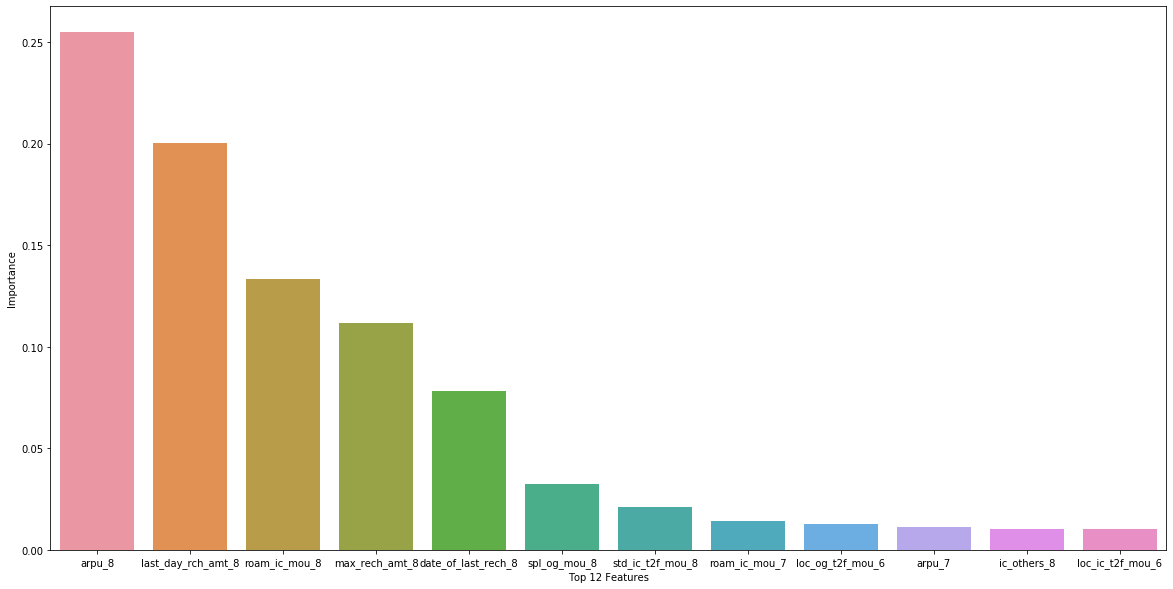

In [167]:
imp=rfc_final.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:12])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

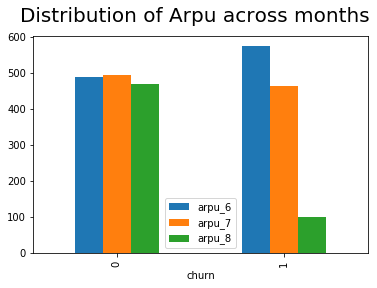

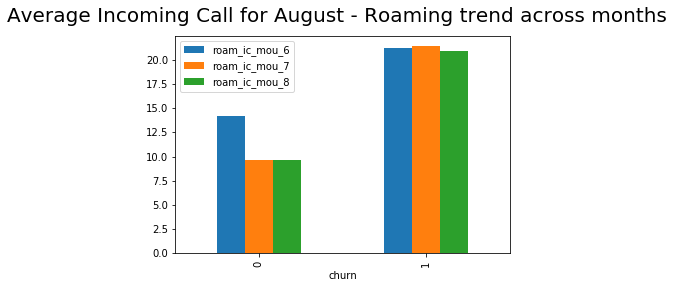

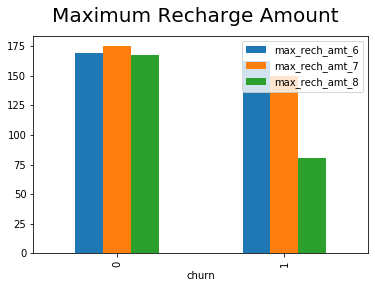

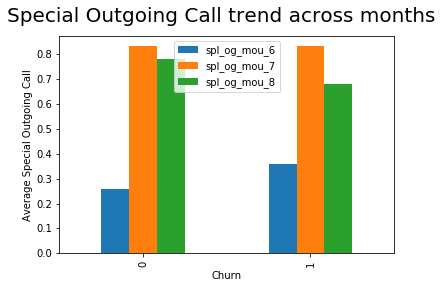

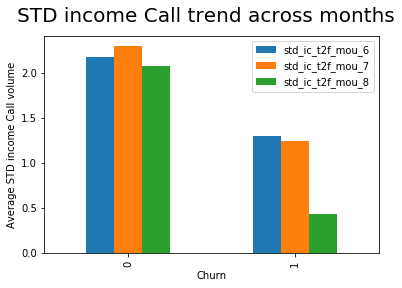

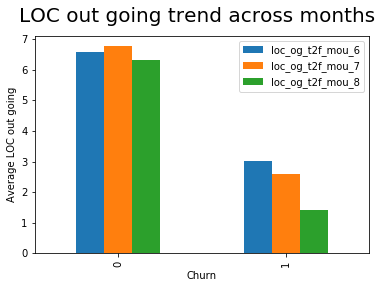

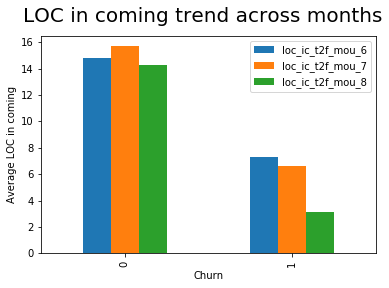

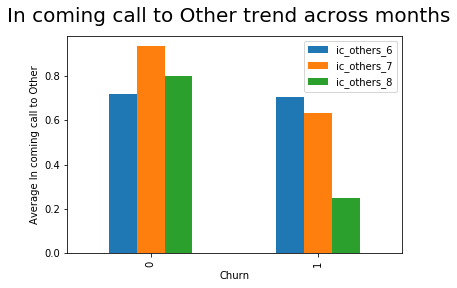

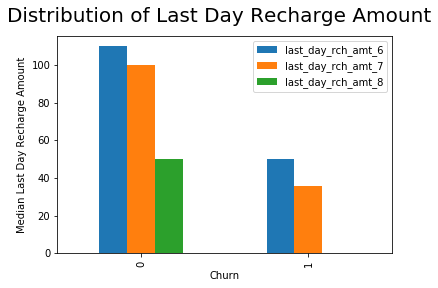

In [168]:
telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['arpu_6', 'arpu_7', 'arpu_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Arpu across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('Average Incoming Call for August - Roaming trend across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'].mean()
df_sample.plot.bar()
plt.suptitle('Maximum Recharge Amount', fontsize=20)
plt.show()


df_sample = telecom_df2.groupby(['churn'])['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'].median()
df_sample.plot.bar()
plt.suptitle('Special Outgoing Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average Special Outgoing Call")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('STD income Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average STD income Call volume")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC out going trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC out going")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC in coming trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC in coming")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['ic_others_6', 'ic_others_7', 'ic_others_8'].mean()
df_sample.plot.bar()
plt.suptitle('In coming call to Other trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average In coming call to Other")
plt.show()

telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Last Day Recharge Amount', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Median Last Day Recharge Amount")
plt.show()

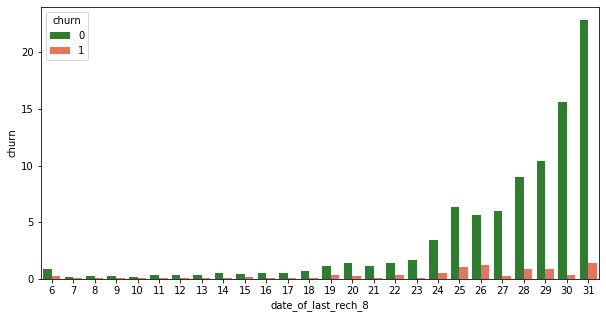

In [169]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

#### Driver Variables of Churn and Churn Analysis & Recommendation
ARPU 7th and 8th - Average Revenue Per User decreases from 6th to 7th month to 8th month as most of the users are churned by 8th month.

date_of_last_rech_8 - Most of the Users are churned between 25th to 31st of the month. Hence providing offers prior to 25th can reduce the churn. Send out periodic offers to customers between 15th of the month to 25th of the month.

last_day_rch_amt_8 - Lower the last day recharge amount higher the churn rate. Focus on customers whos last day recharge amount has decrased. Specialy for customers without any recharge amount.

roam_ic_mou_8 - Higher the incoming roaming amount, higher is the churn rate. Focus on customers whose incoming roaming amount has increased, because they are likely to churn.

std_ic_t2f_mou_8 - Lower the STD incoming call, higher is the churn rate. Focus on customers whose STD incoming call amount has decreased for that month.

max_rech_amt_8- Focus on the customer whoes Avg max recharge amount has been decreased